In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import sympy as sp
from sympy import Symbol, sympify, lambdify, symbols
import scipy
from scipy.optimize import curve_fit 
from IPython.display import display, Latex

In [3]:
class PostProcess:
    
    def __init__(self, fname,data_fname, filt_args,names, variables, E_label):
        self.fname = fname
        self.data_fname = data_fname
        self.filt_args = filt_args
        self.names = names
        self.variables = variables
        self.E_label = E_label
        
        self.sample = pd.read_csv(self.fname, sep=",", names=self.names)
        self.data = pd.read_csv(self.data_fname, sep=",")
        
        self.metal_list = []
        for i in self.data["metal"]:
            if i not in self.metal_list:
                self.metal_list.append(i)
            else:
                continue
        
        self.num_cts = 0
        for i in self.names:
            if (("A" in i) and len(i) == 2):
                self.num_cts = self.num_cts + 1
            else:
                self.num_cts = self.num_cts
                
        self.E = self.data[self.E_label]
        try:
            self.data["merma"]
        except:
            pass
        else:
            self.merma = self.data["merma"]
            
        self.Metrics_symp = []
        
        
            
    def filtrer(self, tres_comp, tres_bic, tres_sse):
        self.sample = self.sample[(self.sample["COMP"]<tres_comp)]
        self.sample = self.sample[(self.sample["BIC"]<tres_bic)]
        self.sample = self.sample[(self.sample["SSE"]<tres_sse)]
        return self.sample
    
    def see_filt(self):
        r = self.filtrer(*self.filt_args)
        return r
    
    def get_item(self, item):
        it = [i for i in range(len(self.sample)) if self.sample["EQSYMPY"].values[i] == item][0]
        result = {"EQSYMPY":self.sample["EQSYMPY"].values[it], "EQLAT":self.sample["EQLAT"].values[it]}
        for i in range(self.num_cts):
            result["A"+str(i)] = float(self.sample["A"+str(i)].values[it])
        eq_lat = result["EQLAT"][2:-2]
        display(Latex(f'$%s$'%eq_lat))
        pars_manual = np.asarray([result["A"+str(i)] for i in range(self.num_cts)])
        pars_symp = np.asarray([np.asarray([j for _ in range(len(self.data))]) for j in pars_manual])
        return result,pars_manual, pars_symp
    
    def fitt_symp(self, item):
        res,_,ps = self.get_item(item)
        eq_to_lam = sympify(res["EQSYMPY"])
        varis = [symbols(i) for i in self.variables]
        params_0 = ["_a"+str(i)+"_" for i in range(self.num_cts)]
        params = [symbols(i) for i in params_0]
        eq_to_sp =lambdify(varis+params ,eq_to_lam)
        args = [i for i in np.asarray(self.data[self.variables]).T] + [j for j in ps]
        fitting_symp = eq_to_sp(*args)
        mae = sum( abs(fitting_symp - self.E) )/len(self.E)
        sse = sum( (fitting_symp - self.E)**2)
        rmse = np.sqrt(sse/len(self.E))
        ss_tot = np.sum((self.E-np.mean(self.E))**2)
        r_squared = 1 - (sse / ss_tot)
        self.Metrics_symp = [mae, rmse, r_squared]
        print(mae)
        print(sse)
        print(r_squared)
        print(rmse)
        plt.scatter(self.E, fitting_symp)
        plt.plot(self.E, self.E, "--", color="black")
        plt.show()
        return fitting_symp
        
    def get_results(self,func, Data, labels, pars, E):
        X = np.asarray(Data[labels]).T
        params, covar = curve_fit(func,X, E, p0=pars)
        fitting = func(X, *params )
        sse = sum( (fitting - E)**2)
        rmse = np.sqrt(sse/len(E))
        MAE = sum(abs(fitting-E))/len(E)
        ss_tot = np.sum((E-np.mean(E))**2)
        r_squared = 1 - (sse / ss_tot)
        res_dict = {"SSE": sse, "MAE": MAE, "r_sq": r_squared,"rmse":rmse,"pars":params,
                    "fitting": fitting}
        return res_dict
        
    def eval_func(self,func, Data, labels, pars, E):
        X = np.asarray(Data[labels]).T
        fitting = func(X, *pars )
        sse = sum( (fitting - E)**2)
        rmse = np.sqrt(sse/len(E))
        MAE = sum(abs(fitting-E))/len(E)
        ss_tot = np.sum((E-np.mean(E))**2)
        r_squared = 1 - (sse / ss_tot)
        res_dict = {"SSE": sse, "MAE": MAE, "r_sq": r_squared,"rmse":rmse,"pars":pars,
                    "fitting": fitting}
        return res_dict
    
    def plotter(self, x, y):
        plt.plot(y, y, "--", color="black")
        plt.scatter(x, y)
        plt.show()
        return
    
    def total_fit(self, main, merma, E, export=[False, "./test.csv"]):
        total_fit = main + merma
        sse = sum( (total_fit - E)**2)
        rmse = np.sqrt(sum( (total_fit - E)**2)/len(E))
        ss_tot = np.sum((E-np.mean(E))**2)
        r_squared = 1 - (sse / ss_tot)
        MAE = sum(abs(total_fit-E))/len(E)
        metrics = [MAE, sse, rmse, r_squared]
        print(MAE)
        print(sse)
        print(rmse)
        print(r_squared)
        if export[0] == False:
            pass
        else:
            final_res = {"total_fit": total_fit, "main_fit": main, "merma_fit":merma,
                         "Energy": E}
            final_res = pd.DataFrame(final_res)
            # final_res.to_csv(export[1], index=False)
    
        fig = plt.figure(1)
        plt.scatter(E, total_fit)
        plt.plot(E, E, "--", color="black")
        plt.show()
        return metrics,total_fit
    
    def Standard_Deviation(self, x, x_mean):
        r = sum( [(i-x_mean)**2 for i in x] )
        R = np.sqrt(r/(len(x)-1))
        return R
    
    def LOUT(self, data, par_main, par_merma, func_main, func_merma, var_main,
            var_merma, special=["co", [-0.00126, -1256.76, 0.227922, -5.324378, 
                                       0.615, 4323000.0]]):
        data_test = [data.loc[data["metal"]!=i] for i in self.metal_list]
        data_train = [data.loc[data["metal"]==i] for i in self.metal_list]
        
        E_test = [i["E"] for i in data_test]
        E_train = [i["E"] for i in data_train]
        
        E_test_merma = [i["merma"] for i in data_test]
        E_train_merma = [i["merma"] for i in data_train]
        
        sse_test = []
        rsq_test = []
        MAE_test = []
        RMSE_test = []
        for i,j,k,l,m,n in zip(data_test, E_test, data_train, E_train, 
                               E_test_merma, E_train_merma):
            if list(set(k["metal"]))[0]!=special[0]:
                r_main = self.get_results(func_main, i, var_main, par_main, j)
                par = r_main["pars"]
            else:
                par = special[1]
            r_merma = self.get_results(func_merma, i, var_merma, par_merma, m)
            p_merma = r_merma["pars"]
            result_locv = self.eval_func(func_main, k, var_main, par, l)
            fitting_merma = self.eval_func(func_merma, k, var_merma, p_merma, n)
            full_res = result_locv["fitting"]+fitting_merma["fitting"]
            self.plotter(full_res, l)
            sse = sum((np.asarray(l)-full_res)**2)
            sse_test.append(sse)
            RMSE_test.append(np.sqrt( sum( (np.asarray(l)-full_res)**2)/len(l)) )
            ss_tot = np.sum((np.asarray(l)-np.mean(l))**2)
            r_squared = 1 - (sse / ss_tot)
            rsq_test.append(r_squared)
            MAE = sum(abs(full_res-np.asarray(l)))/len(l)
            MAE_test.append(MAE)
        Mean_mae = np.mean(MAE_test)
        std_mae = self.Standard_Deviation(MAE_test, Mean_mae)
        print(Mean_mae)
        print(std_mae)
        Mean_sse = np.mean(sse_test)
        std_sse = self.Standard_Deviation(sse_test, Mean_sse)
        print(Mean_sse)
        print(std_sse)
        Mean_rsq = np.mean(rsq_test)
        std_rsq = self.Standard_Deviation(rsq_test, Mean_rsq)
        print(Mean_rsq)
        print(std_rsq)
        Mean_rmse = sum(RMSE_test)/len(RMSE_test)
        std_rmse = self.Standard_Deviation(RMSE_test, Mean_rmse)
        print(Mean_rmse)
        print(std_rmse)
        metrics = [(Mean_mae, std_mae), (Mean_rmse, std_rmse),
                  (Mean_rsq, std_rsq), (Mean_sse, std_sse)]
        return metrics,MAE_test,RMSE_test
    
    def validation(self, data, par_main, par_merma, func_main, func_merma, var_main,
            var_merma):
        Val_MAE = []
        Val_rmse = []
        Val_rsq = []
        Val_sse = []

        Val_main_MAE = []
        Val_main_MAE = []
        Val_main_rmse = []
        Val_main_rsq = []
        Val_main_sse = []
        for _ in range(100):
            ints_test = np.random.randint(0, len(data), 150)
            ints_train = [i for i in range(len(data)) if i not in ints_test]
            test_data = data.iloc[ints_test]
            E_test = test_data["E"]
            merma_test = test_data["merma"]
            train_data = data.iloc[ints_train]
            E_train = train_data["E"]
            merma_train = train_data["merma"]
            r_main = self.get_results(func_main, train_data, var_main, 
                                      par_main, E_train)
            r_merma = self.get_results(func_merma, train_data, var_merma, 
                                       par_merma, merma_train)
            par = r_main["pars"] 
            p_merma = r_merma["pars"]
            result_val = self.eval_func(func_main, test_data, var_main, par, E_test)
            sse_main = sum((np.asarray(E_test)-result_val["fitting"])**2)
            Val_main_sse.append(sse_main)
            rmse_main = np.sqrt(sse_main/len(E_test))
            Val_main_rmse.append(rmse_main)
            ss_tot = np.sum((np.asarray(E_test)-np.mean(E_test))**2)
            r_squared_main = 1 - (sse_main / ss_tot)
            Val_main_rsq.append(r_squared_main)
            MAE_main = sum(abs(result_val["fitting"]-np.asarray(E_test)))/len(E_test)
            Val_main_MAE.append(MAE_main)
            
            fitting_merma = self.eval_func(func_merma, test_data, var_merma
                                           , p_merma, merma_test)
            full_res = result_val["fitting"]+fitting_merma["fitting"]
            self.plotter(full_res, E_test)
            sse = sum((np.asarray(E_test)-full_res)**2)
            Val_sse.append(sse)
            rmse = np.sqrt(sse/len(E_test))
            Val_rmse.append(rmse)
            r_squared = 1 - (sse / ss_tot)
            Val_rsq.append(r_squared)
            MAE = sum(abs(full_res-np.asarray(E_test)))/len(E_test)
            Val_MAE.append(MAE)
        mean_MAE_Val_main = np.mean(Val_main_MAE)
        std_val_mae_main = self.Standard_Deviation(Val_main_MAE, mean_MAE_Val_main)
        print(mean_MAE_Val_main)
        print(std_val_mae_main)
        mean_rsq_Val_main = np.mean(Val_main_rsq)
        std_val_rsq_main = self.Standard_Deviation(Val_main_rsq, mean_rsq_Val_main)
        print(mean_rsq_Val_main)
        print(std_val_rsq_main)
        mean_rmse_Val_main = np.mean(Val_main_rmse)
        std_val_rmse_main = self.Standard_Deviation(Val_main_rmse, mean_rmse_Val_main)
        print(mean_rmse_Val_main)
        print(std_val_rmse_main)
        metrics_main = [(mean_MAE_Val_main, std_val_mae_main), 
                        (mean_rmse_Val_main, std_val_rmse_main),
                       (mean_rsq_Val_main, std_val_rsq_main)]
        
        mean_MAE_Val = np.mean(Val_MAE)
        std_val_mae = self.Standard_Deviation(Val_MAE, mean_MAE_Val)
        print(mean_MAE_Val)
        print(std_val_mae)
        mean_rsq_Val = np.mean(Val_rsq)
        std_val_rsq = self.Standard_Deviation(Val_rsq, mean_rsq_Val)
        print(mean_rsq_Val)
        print(std_val_rsq)

        mean_rmse_Val = np.mean(Val_rmse)
        std_val_rmse = self.Standard_Deviation(Val_rmse, mean_rmse_Val)
        print(mean_rmse_Val)
        print(std_val_rmse)
        metrics_gen_val =[(mean_MAE_Val, std_val_mae), 
                        (mean_rmse_Val, std_val_rmse),
                         (mean_rsq_Val, std_val_rsq)]
        return metrics_main, metrics_gen_val

            
            
    
    
    

In [4]:
pp = PostProcess("final_b2_9.txt", "./bms_full_input_final_mog_nl.csv",[300,300,49],
                 ["COMP", "BIC", "SSE", "A0", "A1", "A2", "A3", "A4","A5", "EQLAT", "EQSYMPY"],
                 ["ncoord", "MOG_b2", "Z", "r", "IE"], "E")

filt = pp.see_filt()

filt

COMP         BIC        SSE        A0            A1           A2  \
189  228.130267  162.819201  48.495270  0.004613  5.262192e+19  -587.053345   
190  214.004896  140.927825  47.004225  0.004741  1.793831e+19  -692.070955   
191  214.004896  140.927825  47.004225  0.004741  1.793831e+19  -692.070955   
192  214.004896  140.927825  47.004225  0.004741  1.793831e+19  -692.070955   
193  214.004896  140.927825  47.004225  0.004741  1.793831e+19  -692.070955   
..          ...         ...        ...       ...           ...          ...   
807  202.187697  114.731429  45.280091  0.004410  6.850697e+20  -548.156923   
808  202.187697  114.731429  45.280091  0.004410  6.850697e+20  -548.156923   
809  202.187697  114.731429  45.280091  0.004410  6.850697e+20  -548.156923   
810  202.187697  114.731429  45.280091  0.004410  6.850697e+20  -548.156923   
811  202.187697  114.731429  45.280091  0.004410  6.850697e+20  -548.156923   

            A3         A4          A5  \
189 -25.115813 -23.009098    6.564398   
190 -24.924073 -22.278796  391.558516   
191 -24.924073 -22.278796  391.558516   
192 -24.924073 -22.278796  391.558516   
193 -24.924073 -22.278796  391.558516   
..         ...        ...         ...   
807 -26.196107 -25.265162    4.770712   
808 -26.196107 -25.265162    4.770712   
809 -26.196107 -25.265162    4.770712   
810 -26.196107 -25.265162    4.770712   
811 -26.196107 -25.265162    4.770712   

                                                 EQLAT  \
189  \[- \frac{ncoord^{2}}{c_{5}} \left(r + \left(c...   
190  \[- \frac{ncoord^{2}}{c_{5}} \left(r + \left(c...   
191  \[- \frac{ncoord^{2}}{c_{5}} \left(r + \left(c...   
192  \[- \frac{ncoord^{2}}{c_{5}} \left(r + \left(c...   
193  \[- \frac{ncoord^{2}}{c_{5}} \left(r + \left(c...   
..                                                 ...   
807  \[- \frac{ncoord^{2}}{c_{6}} \left(2 ncoord + ...   
808  \[- \frac{ncoord^{2}}{c_{6}} \left(2 ncoord + ...   
809  \[- \frac{ncoord^{2}}{c_{6}} \left(2 ncoord + ...   
810  \[- \frac{ncoord^{2}}{c_{6}} \left(2 ncoord + ...   
811  \[- \frac{ncoord^{2}}{c_{6}} \left(2 ncoord + ...   

                                               EQSYMPY  
189  -((((((((Z + _a3_) * _a0_) ** (abs((Z + ncoord...  
190  -((((((((Z + _a3_) * _a0_) ** (abs((Z + ncoord...  
191  -((((((((Z + _a3_) * _a0_) ** (abs((Z + ncoord...  
192  -((((((((Z + _a3_) * _a0_) ** (abs((Z + ncoord...  
193  -((((((((Z + _a3_) * _a0_) ** (abs((Z + ncoord...  
..                                                 ...  
807  -((((((((Z + _a3_) * _a0_) ** (abs((Z + _a5_))...  
808  -((((((((Z + _a3_) * _a0_) ** (abs((Z + _a5_))...  
809  -((((((((Z + _a3_) * _a0_) ** (abs((Z + _a5_))...  
810  -((((((((Z + _a3_) * _a0_) ** (abs((Z + _a5_))...  
811  -((((((((Z + _a3_) * _a0_) ** (abs((Z + _a5_))...  

[623 rows x 11 columns]

In [5]:
# filt_eqs = list(filt["EQSYMPY"])
# filt_eqs

In [6]:
#this comes from final_b2_9.txt
result,pars_manual, pars_symp = pp.get_item('-((((((((Z + _a3_) * _a0_) ** (abs((Z + _a5_)) / log(_a1_))) * -(((_a2_ / ((Z + _a4_) * (ncoord / MOG_b2))) + (ncoord ** 2)))) + r) * ((ncoord * ((_a5_ / ((_a3_ + (Z + IE)) * MOG_b2)) + (ncoord + ncoord))) / _a4_)) * ncoord))')



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.20035719865698415
45.28010353112494
0.8541644767032215
0.25415268174153144


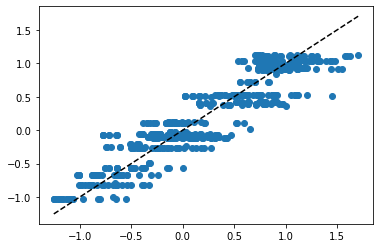

In [7]:

res= pp.fitt_symp('-((((((((Z + _a3_) * _a0_) ** (abs((Z + _a5_)) / log(_a1_))) * -(((_a2_ / ((Z + _a4_) * (ncoord / MOG_b2))) + (ncoord ** 2)))) + r) * ((ncoord * ((_a5_ / ((_a3_ + (Z + IE)) * MOG_b2)) + (ncoord + ncoord))) / _a4_)) * ncoord))')


In [8]:
merma_fin = pp.E - res
data_merma = pp.data.copy()
data_merma["merma"] = merma_fin
# data_merma.to_csv("./merma_fin_1.csv", index=False)

In [9]:
pp_merma = PostProcess("./merma_fin_fin_1.txt", "./merma_fin_1.csv",[300,300,35],
                 ["COMP", "BIC", "SSE", "A0", "A1", "A2", "EQLAT", "EQSYMPY"],
                 ["opc", "m_MCe3", "m_Ce3"], "merma")

filt_merma = pp_merma.see_filt()

# filt_merma

In [10]:
# filt_eqs_merma = list(filt_merma["EQSYMPY"])
# filt_eqs_merma

In [11]:
result_merma,pars_manual_merma, pars_symp_merma = pp_merma.get_item('(((exp((((m_MCe3 / m_Ce3) ** _a0_) * (m_MCe3 + _a0_))) * ((m_MCe3 + m_Ce3) * _a1_)) ** 2) * sin((opc * _a0_)))')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.2551010975573333
77.37679762177164
-0.7127492159505515
0.33223575327086247


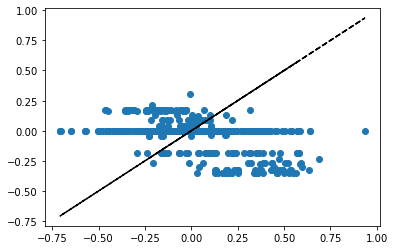

In [12]:
res_merma = pp_merma.fitt_symp('(((exp((((m_MCe3 / m_Ce3) ** _a0_) * (m_MCe3 + _a0_))) * ((m_MCe3 + m_Ce3) * _a1_)) ** 2) * sin((opc * _a0_)))')

0.17317803756802594
34.581142713081746
0.22210618938349316
0.8886230672971793


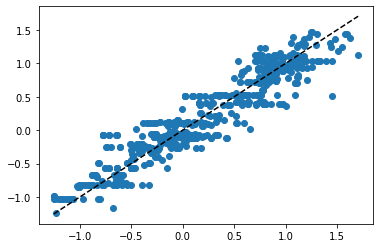

In [13]:
metrics_tot, dd = pp_merma.total_fit(res, -res_merma, pp.E)

In [14]:
pp4 = PostProcess("final_b2_23.txt", "./bms_full_input_final_mog_nl.csv",[300,300,35.03],
                 ["COMP", "BIC", "SSE", "A0", "A1", "A2", "A3", "A4","A5", "EQLAT", "EQSYMPY"],
                 ["ncoord", "MOG_b2", "Z", "r", "IE"], "E")

filt4 = pp4.see_filt()

# filt4

In [15]:
# filt_eqs_4 = list(filt4["EQSYMPY"])
# filt_eqs_4

In [16]:
result4,pars_manual4, pars_symp4 = pp4.get_item('(((((((((r / (r + cos((r * (_a5_ / _a1_))))) ** 2) / _a1_) / ((((Z + IE) ** (_a3_ + ncoord)) * _a1_) + MOG_b2)) / -(((MOG_b2 + _a4_) ** 2))) + (((MOG_b2 + _a3_) ** ncoord) * (_a0_ * cos(r)))) + _a2_) * ncoord) + (MOG_b2 ** 2))')

pars_manual4

<IPython.core.display.Latex object>

array([-1.06000000e-03, -1.25676526e+03,  2.67922000e-01, -5.52437800e+00,
        6.14414000e-01,  4.32292853e+06])

<IPython.core.display.Latex object>

0.18061141330182626
35.0230783431924
0.88719970672919
0.2235209058545862


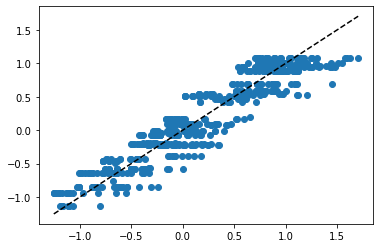

In [17]:
res4 = pp4.fitt_symp('(((((((((r / (r + cos((r * (_a5_ / _a1_))))) ** 2) / _a1_) / ((((Z + IE) ** (_a3_ + ncoord)) * _a1_) + MOG_b2)) / -(((MOG_b2 + _a4_) ** 2))) + (((MOG_b2 + _a3_) ** ncoord) * (_a0_ * cos(r)))) + _a2_) * ncoord) + (MOG_b2 ** 2))')

In [18]:
merma4 = pp4.E - res4
merma_data_4 = pp4.data.copy()
merma_data_4["merma"] = merma4
# merma_data_4.to_csv("./merma_fin_4.csv", index=False)
merma_data_4

metal         E  ncoord   Z     IE      homo    MOG_81    MOG_97  \
0      co -1.254532       4  27  33.50 -4.173892  3.985078  4.118778   
1      co -1.252940       4  27  33.50 -4.173892  3.985078  4.118778   
2      co -1.248888       4  27  33.50 -4.173892  3.985078  4.118778   
3      co -1.242027       4  27  33.50 -4.173892  3.985078  4.118778   
4      co -1.235380       4  27  33.50 -4.173892  3.985078  4.118778   
..    ...       ...     ...  ..    ...       ...       ...       ...   
696    rh  1.551345       3  45  18.08 -4.803866  4.197547  4.197547   
697    ir  1.579275       3  77  17.00 -4.947573  4.297044  4.250405   
698    ir  1.594908       3  77  17.00 -4.947573  4.297044  4.250405   
699    ir  1.625722       3  77  17.00 -4.947573  4.297044  4.250405   
700    ir  1.706937       3  77  28.00 -4.947573  4.297044  4.250405   

       MOG_b1    MOG_b2  min_MCe3  m_MCe3  m_Ce3  min_Ce3     r       opc  \
0   -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
1   -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
2   -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
3   -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
4   -0.577163 -0.577163      0.71    1.29   1.14     1.00  1.26  1.333333   
..        ...       ...       ...     ...    ...      ...   ...       ...   
696 -0.296247 -0.296247      1.58    1.85   1.00     1.00  1.35  2.000000   
697 -0.473476 -0.473476      1.58    1.85   1.00     1.00  1.37  2.000000   
698 -0.473476 -0.473476      1.58    1.85   1.00     1.00  1.37  2.000000   
699 -0.473476 -0.473476      1.58    1.58   1.00     1.00  1.37  2.000000   
700 -0.473476 -0.473476      0.71    1.00   1.14     1.00  1.37  2.000000   

                                            plot_label     merma  
0    M: Co; Coord: 4; OS: 3; IDs: 28_32_33; mean(d-... -0.311433  
1    M: Co; Coord: 4; OS: 3; IDs: 31_33_35; mean(d-... -0.309841  
2    M: Co; Coord: 4; OS: 3; IDs: 28_32_36; mean(d-... -0.305789  
3    M: Co; Coord: 4; OS: 3; IDs: 30_31_35; mean(d-... -0.298928  
4    M: Co; Coord: 4; OS: 3; IDs: 31_32_35; mean(d-... -0.292281  
..                                                 ...       ...  
696  M: Rh; Coord: 3; OS: 2; IDs: 33_36; mean(d-Ce3...  0.547210  
697  M: Ir; Coord: 3; OS: 2; IDs: 30_33; mean(d-Ce3...  0.497047  
698  M: Ir; Coord: 3; OS: 2; IDs: 33_36; mean(d-Ce3...  0.512680  
699  M: Ir; Coord: 3; OS: 2; IDs: 30_36; mean(d-Ce3...  0.543494  
700  M: Ir; Coord: 3; OS: 3; IDs: 28_29_32; mean(d-...  0.625255  

[701 rows x 18 columns]

In [19]:
pp_merma_2 = PostProcess("./merma_fin_end_10.txt", "./merma_fin_4.csv",[300,300,26.6],
                 ["COMP", "BIC", "SSE", "A0", "A1", "A2", "EQLAT", "EQSYMPY"],
                 ["opc", "min_MCe3", "m_Ce3"], "merma")

filt_merma_2 = pp_merma_2.see_filt()

# filt_merma_2

In [20]:
# filt_eqs_merma_2 = list(filt_merma_2["EQSYMPY"])
# filt_eqs_merma_2

In [21]:
result_merma2,pars_manual_merma2, pars_symp_merma_2 = pp_merma_2.get_item('((((cos((_a1_ * ((opc ** 2) + ((_a2_ + _a1_) * (opc * _a1_))))) / (((_a2_ ** 2) * min_MCe3) + (-(_a2_) * m_Ce3))) * min_MCe3) + m_Ce3) / _a1_)')
pars_manual_merma2

<IPython.core.display.Latex object>

array([  1.      , -27.011126,   0.293669])

In [22]:
result_merma2["EQLAT"]

'\\[\\frac{1}{c_{1}} \\left(m_{Ce3} + \\frac{min_{MCe3}}{c_{2}^{2} min_{MCe3} - c_{2} m_{Ce3}} \\cos{\\left (c_{1} \\left(c_{1} opc \\left(c_{1} + c_{2}\\right) + opc^{2}\\right) \\right )}\\right)\\]'

<IPython.core.display.Latex object>

0.15188428502229714
26.018014928680056
0.25711796528932684
0.19265401763697823


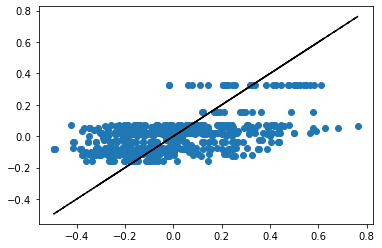

In [23]:
merma_2 = pp_merma_2.fitt_symp('((((cos((_a1_ * ((opc ** 2) + ((_a2_ + _a1_) * (opc * _a1_))))) / (((_a2_ ** 2) * min_MCe3) + (-(_a2_) * m_Ce3))) * min_MCe3) + m_Ce3) / _a1_)')

0.15188428502229714
26.018014928680056
0.19265401763697823
0.9162026911078226


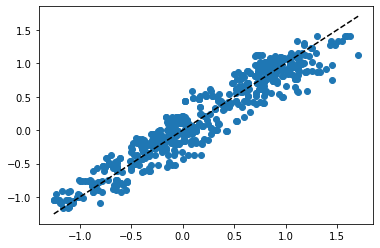

In [24]:
metrics_tot_2, total_fit = pp_merma_2.total_fit(res4, merma_2, pp4.E, export=[True, 
                                                            "./to_Julian_MOG_b2_2.csv"])


In [25]:


def main_6(x, p1, p2, p3, p4, p5, p6):
    r = (((((((((x[3] / (x[3] + np.cos((x[3] * (p6 / p2))))) ** 2) / p2) / 
              ((((x[2] + x[4]) ** (p4 + x[0])) * p2) + x[1])) / -(((x[1] + p5) ** 2)))
            + (((x[1] + p4) ** x[0]) * (p1 * np.cos(x[3])))) + p3) * x[0]) 
         + (x[1] ** 2))
    return r

res_main_manual = pp4.get_results(main_6, pp4.data, pp4.variables, pars_manual4, pp4.E)
res_main_manual["pars"]

array([-1.05989279e-03, -1.25675123e+03,  2.67922744e-01, -5.52437050e+00,
        6.14413942e-01,  4.32288029e+06])

In [26]:
data_by_metal = {i:pp_merma_2.data.loc[pp_merma_2.data["metal"]==i] for i in pp4.metal_list}
E_by_metal = [data_by_metal[i]["E"] for i in pp4.metal_list]

data_by_ncoord = {str(i):pp_merma_2.data.loc[pp_merma_2.data["ncoord"]==i] for i in [2, 3, 4]}
E_by_ncoord = [data_by_ncoord[str(i)]["E"] for i in [2, 3, 4]]

data_by_metal_by_ncoord = [ [data_by_metal[i].loc[data_by_metal[i]["ncoord"]==j]
                             for j in [2,3,4]] for i in pp4.metal_list]
E_by_metal_by_ncoord = [ [j["E"] for j in i] for i in data_by_metal_by_ncoord]

train_no_co =  pp4.data.loc[pp4.data["metal"]!="co"]

train_all_no_co = pp4.eval_func(main_6, train_no_co, pp4.variables, 
                          [-1.16000000e-03, -1.25676e+03,2.37922000e-01,-5.42437800e+00,
                           6.15e-01, 4.323e+06], train_no_co["E"])

test_co = pp4.eval_func(main_6, data_by_metal["co"], pp4.variables, 
                          train_all_no_co["pars"], data_by_metal["co"]["E"])

print(train_all_no_co["pars"])
print(pars_manual4)
print(test_co["MAE"])
print(train_all_no_co["MAE"])

pars_manual_co = train_all_no_co["pars"]

rs = []
MOGs = []
Zs = []
IEs = []
for i in pp4.metal_list:
    MOGs.append(list(data_by_metal[i]["MOG_b2"])[0])
    rs.append(list(data_by_metal[i]["r"])[0])
    Zs.append(list(data_by_metal[i]["Z"])[0])
    ies = data_by_metal[i]["IE"]
    IEs.append(set(ies))
data_see = pd.DataFrame({"metal":pp4.metal_list, "MOGs":MOGs, "rs":rs, "Z":Zs})

data_see

print(IEs)

[-0.00116, -1256.76, 0.237922, -5.424378, 0.615, 4323000.0]
[-1.06000000e-03 -1.25676526e+03  2.67922000e-01 -5.52437800e+00
  6.14414000e-01  4.32292853e+06]
0.2182700178764405
0.20204620690057742


metal      MOGs    rs   Z
0    co -0.577163  1.26  27
1    ni -0.414000  1.21  28
2    cu -0.407577  1.38  29
3    pd -0.221278  1.31  46
4    pt -0.231470  1.28  78
5    au -0.016842  1.44  79
6    ir -0.473476  1.37  77
7    rh -0.296247  1.35  45
8    ag -0.040291  1.53  47

[{33.5, 51.2, 17.0844, 7.881010000000001}, {0.0, 18.168838, 7.6398}, {20.29239, 7.726380000000001}, {8.336839, 0.0, 19.43}, {8.9587, 0.0, 18.56}, {9.225554, 30.0}, {0.0, 40.0, 8.967, 17.0, 28.0}, {0.0, 7.4589, 42.0, 18.08, 31.06}, {21.4844, 7.576233999999999}]


(array([ 63., 135.,  43.,  18., 442.]),
 array([-1.8611855 , -1.44193587, -1.02268624, -0.60343661, -0.18418698,
         0.23506265]),
 <BarContainer object of 5 artists>)

{'co': 0.6829830455550031, 'ni': 0.737325734577324, 'cu': 0.7669738031670467, 'pd': 0.8305153591492056, 'pt': 0.8911735573889171, 'au': 0.7861463940124438, 'ir': 0.9388424937600128, 'rh': 0.8948352986827018, 'ag': 0.7804614041359993}
{'2': 0.5514903566934923, '3': 0.7140800026404576, '4': 1.062833124806473}


[array([-0.00267713, -0.00267713, -0.00267713, -0.00267713, -0.00267713,
        -0.00267713, -0.00267713, -0.00267713, -0.00267713]),
 array([0.02234602, 0.02234602, 0.02234602, 0.02234602, 0.02234602,
        0.02234602, 0.02234602, 0.02234602, 0.02234602]),
 array([-0.16579736, -0.16579736, -0.16579736, -0.16579736, -0.16579736,
        -0.16579736, -0.16579736, -0.16579736, -0.16579736, -0.16579736,
        -0.16579736, -0.16579736, -0.16579736, -0.16579736, -0.16579736,
        -0.16579736, -0.16579736, -0.16579736, -0.16579736, -0.16579736,
        -0.16579736, -0.16579736, -0.16579736, -0.16579736, -0.16579736,
        -0.16579736, -0.16579736, -0.16579736, -0.16579736, -0.16579736,
        -0.16579736, -0.16579736, -0.16579736, -0.16579736, -0.16579736,
        -0.16579736, -0.16579736, -0.16579736])]

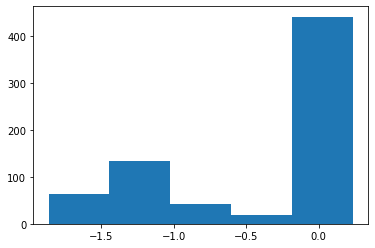

In [27]:
def main_6_1(x, p1, p2, p3, p4, p5, p6):
    r = (((x[1] + p4) ** x[0]) * (p1 * np.cos(x[3])))*x[0]
    return r

term_6_1 = main_6_1(np.asarray(pp4.data[pp4.variables]).T, *res_main_manual["pars"])



plt.hist(term_6_1, bins=5)
term_6_1_to_julian = pd.DataFrame({"term_1":term_6_1, 
                                   "plot_label":pp4.data["plot_label"]})
# term_6_1_to_julian.to_csv("./new_term_1.csv", index=False)

term_6_1_by_metal = [main_6_1(np.asarray(data_by_metal[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in pp4.metal_list]

term_6_1_by_ncoord = [main_6_1(np.asarray(data_by_ncoord[str(i)][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in [2,3,4]]

err_6_1_by_metal = {z:sum(abs(i - j))/len(j) for i,j,z in 
                  zip(term_6_1_by_metal, E_by_metal, pp4.metal_list)}

err_6_1_by_ncoord = {z:sum(abs(i - j))/len(j) for i,j,z in 
                  zip(term_6_1_by_ncoord, E_by_ncoord, ["2", "3", "4"])}

print(err_6_1_by_metal)
print(err_6_1_by_ncoord)
term_6_1_by_metal_by_ncoord = [ [ main_6_1(np.asarray(j[pp4.variables]).T, 
                                           *res_main_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]

term_6_1_by_metal_by_ncoord[8]


(array([ 24.,  82.,  24.,  53., 518.]),
 array([-2.00384694, -1.60374155, -1.20363616, -0.80353077, -0.40342538,
        -0.00331998]),
 <BarContainer object of 5 artists>)

[array([-1.11967378, -1.11967378, -1.11967378, -1.11967378, -1.11967378,
        -1.11284606, -1.11284606, -1.11967378, -1.11284606, -1.11967378,
        -1.11284606, -1.11967378, -1.11284606, -1.11967378]),
 array([-1.41611327, -1.41611327, -1.41611327, -1.41611327, -1.41611327,
        -1.41611327, -1.41611327, -1.41611327, -1.41611327, -1.41611327,
        -1.41611327, -1.41611327, -1.41611327, -1.41611327, -1.41611327,
        -1.41611327, -1.41611327, -1.41611327, -1.41611327, -1.41611327,
        -1.41611327, -1.41611327, -1.41611327, -1.41611327, -1.41611327,
        -1.23374926, -1.41611327, -1.41611327, -1.41611327, -1.41611327,
        -1.41611327, -1.0070425 ]),
 array([-0.22912641, -0.22912641, -0.22912641, -0.22912641, -0.22912641,
        -0.22912641, -0.22912641, -0.22912641, -0.22912641, -0.22912641,
        -0.22912641, -0.22912641, -0.22912641, -0.22912641, -0.22912641,
        -0.22912641, -0.22912641, -0.22912641, -0.22912641, -0.22912641,
        -0.22912641, -0.22

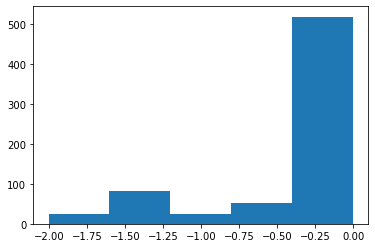

In [28]:
def main_6_2(x, p1, p2, p3, p4, p5, p6):
    r = (((((x[3] / (x[3] + np.cos((x[3] * (p6 / p2))))) ** 2) / p2) / 
          ((((x[2] + x[4]) ** (p4 + x[0])) * p2) + x[1])) / -(((x[1] + p5) ** 2)))*x[0]
    return r
term_6_2 = main_6_2(np.asarray(pp4.data[pp4.variables]).T, *res_main_manual["pars"])



plt.hist(term_6_2, bins=5)
term_6_2_to_julian = pd.DataFrame({"term_1":term_6_2, 
                                   "plot_label":pp4.data["plot_label"]})
# term_6_2_to_julian.to_csv("./new_term_2.csv", index=False)

term_6_2_by_metal = [main_6_2(np.asarray(data_by_metal[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in pp4.metal_list]

term_6_2_by_ncoord = [main_6_2(np.asarray(data_by_ncoord[str(i)][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in [2,3,4]]

err_6_2_by_metal = {z:sum(abs(i - j))/len(j) for i,j,z in 
                  zip(term_6_2_by_metal, E_by_metal, pp4.metal_list)}

err_6_2_by_ncoord = {z:sum(abs(i - j))/len(j) for i,j,z in 
                  zip(term_6_2_by_ncoord, E_by_ncoord, ["2", "3", "4"])}
term_6_2_by_metal_by_ncoord = [ [ main_6_2(np.asarray(j[pp4.variables]).T, 
                                           *res_main_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]

#print(err_6_2_by_metal)
#print(err_6_2_by_ncoord)
term_6_2_by_metal_by_ncoord[1]

In [29]:
err_6_1_2_by_metal = {z:sum(abs(i+k - j))/len(j) for i,j,z,k in 
                  zip(term_6_2_by_metal, E_by_metal, pp4.metal_list,
                      term_6_1_by_metal)}
err_6_1_2_by_metal

{'co': 1.1131271244327705,
 'ni': 1.07393563130817,
 'cu': 1.1046219086674829,
 'pd': 0.8474031037168238,
 'pt': 0.9408398560311965,
 'au': 0.9470080622214082,
 'ir': 1.0005548989488033,
 'rh': 0.9105603200525326,
 'ag': 0.9174575355575073}

In [30]:
def main_6_2_num(x, p1, p2, p3, p4, p5, p6):
    r = x[0]*x[3]**2*((x[2] + x[4]) ** (-p4 - x[0]))
    return r

def main_6_2_denom(x, p1, p2, p3, p4, p5, p6):
    r = -p2*(x[1]+p5)**2*(x[1]*(x[4]+x[2])**(-p4-x[0])+p2)*(x[3]+np.cos(x[3]*p6/p2))**2
    return r
num = main_6_2_num(np.asarray(pp4.data[pp4.variables]).T, 
                   *res_main_manual["pars"])
denom = main_6_2_denom(np.asarray(pp4.data[pp4.variables]).T, 
                       *res_main_manual["pars"])
num_by_metal = [main_6_2_num(np.asarray(data_by_metal[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in pp4.metal_list]
num_by_ncoord = [main_6_2_num(np.asarray(data_by_ncoord[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in ["2", "3", "4"]]
num_by_metal_by_ncoord = [ [ main_6_2_num(np.asarray(j[pp4.variables]).T, 
                                           *res_main_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]
num_by_metal_by_ncoord[0]

[array([1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901, 1980798.96270901,
        1980798.96270901, 1980798.96270901,  867813.55894168,
         867813.55894168,  867813.55894168, 1980798.96270901,
        1980798.96270901, 1980798.96270901]),
 array([149855.62478938, 149855.62478938, 149855.62478938, 149855.62478938,
        149855.62478938, 149855.62478938, 149855.62478938, 149855.62478938,
        149855.62478938, 149855.62478938, 149855.62478938, 149855.62478938,
        149855.62478938,  67397.95583162, 149855.62478938, 149855.62478938,
        149855.62478938, 14985

In [31]:
denom_by_metal = [main_6_2_denom(np.asarray(data_by_metal[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in pp4.metal_list]
denom_by_ncoord = [main_6_2_denom(np.asarray(data_by_ncoord[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in ["2", "3", "4"]]
denom_by_metal_by_ncoord = [ [ main_6_2_denom(np.asarray(j[pp4.variables]).T, 
                                           *res_main_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]
denom_by_metal_by_ncoord[0]

[array([-1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352, -1391615.27787352,
        -1391615.27787352, -1391615.27787352,  -612404.39071808,
         -612404.39071808,  -612404.39071808, -1391615.27787352,
        -1391615.27787352, -1391615.27787352]),
 array([-74783.96769651, -74783.96769651, -74783.96769651, -74783.96769651,
        -74783.96769651, -74783.96769651, -74783.96769651, -74783.96769651,
        -74783.96769651, -74783.96769651, -74783.96769651, -74783.96769651,
        -74783.96769651, -36297.74067511, -74783.96769651, -74783.96769651

In [32]:
def power_IP_Z(x, p1, p2, p3, p4, p5, p6):
    r = x[1]*((x[2] + x[4]) ** (-p4 - x[0]))
    return r

pIZ = [ [power_IP_Z(np.asarray(j[pp4.variables]).T, 
                                           *res_main_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]
print(pIZ[5])
print(pIZ[8])



[array([-121168.39253471, -121168.39253471, -121168.39253471,
       -121168.39253471, -121168.39253471, -121168.39253471,
       -121168.39253471, -121168.39253471, -121168.39253471]), array([-1373.39338821, -1373.39338821, -1373.39338821, -1373.39338821,
       -1373.39338821, -1373.39338821, -1373.39338821, -1373.39338821,
       -1373.39338821]), array([-21.48754049, -21.48754049, -21.48754049, -21.48754049,
       -21.48754049, -21.48754049, -21.48754049, -21.48754049,
       -21.48754049, -21.48754049, -15.56684346, -15.56684346,
       -15.56684346, -15.56684346, -15.56684346, -21.48754049,
       -21.48754049, -21.48754049])]
[array([-53340.24616206, -53340.24616206, -53340.24616206, -53340.24616206,
       -53340.24616206, -53340.24616206, -53340.24616206, -53340.24616206,
       -53340.24616206]), array([-977.35300245, -977.35300245, -977.35300245, -977.35300245,
       -977.35300245, -977.35300245, -977.35300245, -977.35300245,
       -977.35300245]), array([-17.90803305, -1

<ipython-input-33-ff540fee2a09>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rs_0 = np.asarray([np.asarray(data_by_metal[i]["r"]) for i in pp4.metal_list])


Text(1.26, 2.2085455298935734, 'co')

Text(1.21, 0.12462685462753963, 'ni')

Text(1.38, 0.15031220657150496, 'cu')

Text(1.31, 3.431070838125452, 'pd')

Text(1.28, 1.4106541534227128, 'pt')

Text(1.44, 0.9481426792622588, 'au')

Text(1.37, 5.613817280772132, 'ir')

Text(1.35, 5.230805340558233, 'rh')

Text(1.53, 0.5075137166635375, 'ag')

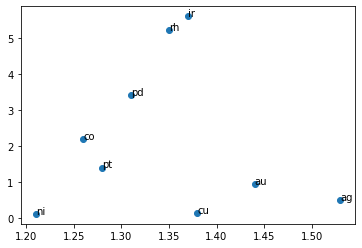

In [33]:
def cos_r(x, p1, p2, p3, p4, p5, p6):
    #r = (x[3]+np.cos(x[3]*p6/p2))**2
    r = (x[3]+np.cos(x[3]*p6/p2))**2
    return r
cr = cos_r(np.asarray(pp4.data[pp4.variables]).T, 
                            *res_main_manual["pars"])
cos_r_by_metal = [cos_r(np.asarray(data_by_metal[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in pp4.metal_list]

rs_0 = np.asarray([np.asarray(data_by_metal[i]["r"]) for i in pp4.metal_list])
rs = [i[0] for i in rs_0]

list_cr_by_metal = [ i[0] for i in cos_r_by_metal]

plt.scatter(rs, list_cr_by_metal)
for i,j,k in zip(rs, list_cr_by_metal, pp4.metal_list):
    plt.annotate(k,(i,j))
#list_cr_by_metal


(array([104., 155., 121., 190., 131.]),
 array([0.53612914, 0.70986485, 0.88360056, 1.05733627, 1.23107199,
        1.4048077 ]),
 <BarContainer object of 5 artists>)

1.404807696884439
0.5361291405392048
[array([0.70724149, 0.70724149, 0.70724149, 0.70724149, 0.70724149,
       0.70724149, 0.70724149, 0.70724149, 0.70724149, 0.70724149,
       0.70724149, 0.70724149, 0.70724149, 0.70724149]), array([0.97516423, 0.97516423, 0.97516423, 0.97516423, 0.97516423,
       0.97516423, 0.97516423, 0.97516423, 0.97516423, 0.97516423,
       0.97516423, 0.97516423, 0.97516423, 0.97516423, 0.97516423,
       0.97516423, 0.97516423, 0.97516423, 0.97516423, 0.97516423,
       0.97516423, 0.97516423, 0.97516423, 0.97516423, 0.97516423,
       0.97516423, 0.97516423, 0.97516423, 0.97516423, 0.97516423,
       0.97516423, 0.97516423]), array([1.24308697, 1.24308697, 1.24308697, 1.24308697, 1.24308697,
       1.24308697, 1.24308697, 1.24308697, 1.24308697, 1.24308697,
       1.24308697, 1.24308697, 1.24308697, 1.24308697, 1.24308697,
       1.24308697, 1.24308697, 1.24308697, 1.24308697, 1.24308697,
       1.24308697, 1.24308697, 1.24308697, 1.24308697, 1.24308697,
 

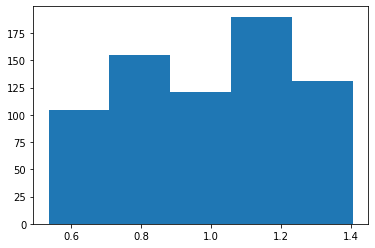

In [34]:

def main_6_3(x, p1, p2, p3, p4, p5, p6):
    r = x[1]**2 + x[0]*p3
    return r
term_6_3 = main_6_3(np.asarray(pp4.data[pp4.variables]).T, *res_main_manual["pars"])



plt.hist(term_6_3, bins=5)
term_6_3_to_julian = pd.DataFrame({"term_3":term_6_3, 
                                   "plot_label":pp4.data["plot_label"]})
# term_6_3_to_julian.to_csv("./new_term_3.csv", index=False)

term_6_3_by_metal = [main_6_3(np.asarray(data_by_metal[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in pp4.metal_list]
print(max(term_6_3))
print(min(term_6_3))
term_6_3_by_metal_by_ncoord = [ [ main_6_3(np.asarray(j[pp4.variables]).T, 
                                           *res_main_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]
print(term_6_3_by_metal_by_ncoord[1])

In [35]:
err_6_1_2_3_by_metal = {z:sum(abs(i+k+l - j))/len(j) for i,j,z,k,l in 
                  zip(term_6_2_by_metal, E_by_metal, pp4.metal_list,
                      term_6_1_by_metal, term_6_3_by_metal)}
err_6_1_2_3_by_metal

{'co': 0.17020311949287503,
 'ni': 0.16308163361478434,
 'cu': 0.19797302303248956,
 'pd': 0.17191013872560373,
 'pt': 0.22962511794149734,
 'au': 0.19406500378929742,
 'ir': 0.20507915217320508,
 'rh': 0.1651944616251728,
 'ag': 0.1134915326511944}

(array([258., 112., 153.,  95.,  83.]),
 array([2.83653223e-04, 6.68502670e-02, 1.33416881e-01, 1.99983495e-01,
        2.66550108e-01, 3.33116722e-01]),
 <BarContainer object of 5 artists>)

0.33311672225181216
0.0002836532228913724
[0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339 0.00162339
 0.00162339 0.00162339]


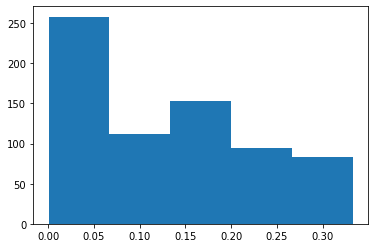

In [36]:

def main_6_3_1(x, p1, p2, p3, p4, p5, p6):
    r = x[1]**2
    return r
term_6_3_1 = main_6_3_1(np.asarray(pp4.data[pp4.variables]).T, *res_main_manual["pars"])



plt.hist(term_6_3_1, bins=5)

term_6_3_1_by_metal = [main_6_3_1(np.asarray(data_by_metal[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in pp4.metal_list]
print(max(term_6_3_1))
print(min(term_6_3_1))

print(term_6_3_1_by_metal[8])

(array([171.,   0., 233.,   0., 297.]),
 array([0.53584549, 0.64301458, 0.75018368, 0.85735278, 0.96452188,
        1.07169097]),
 <BarContainer object of 5 artists>)

1.0716909746326269
0.5358454873163134
[0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549 0.53584549
 0.53584549 0.53584549 0

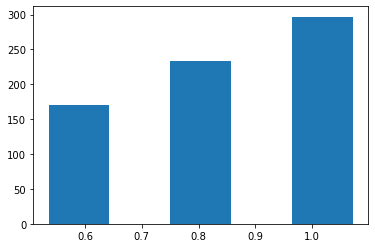

In [37]:

def main_6_3_2(x, p1, p2, p3, p4, p5, p6):
    r =  x[0]*p3
    return r
term_6_3_2 = main_6_3_2(np.asarray(pp4.data[pp4.variables]).T, *res_main_manual["pars"])



plt.hist(term_6_3_2, bins=5)

term_6_3_2_by_ncoord = [main_6_3_2(np.asarray(data_by_ncoord[i][pp4.variables]).T, 
                            *res_main_manual["pars"]) for i in ["2", "3", "4"]]
print(max(term_6_3_2))
print(min(term_6_3_2))

print(term_6_3_2_by_ncoord[0])

In [38]:
term_6_1 + term_6_2 + term_6_3 - res4

array([ 1.93629443e-04,  1.93629443e-04,  1.93629443e-04,  1.93629443e-04,
        1.93629443e-04,  1.93629443e-04,  1.93629443e-04,  1.93707843e-04,
        1.93707843e-04,  1.93629443e-04,  1.93707843e-04,  1.93629443e-04,
        1.93707843e-04,  1.93629443e-04,  1.93629443e-04,  1.93707843e-04,
        1.93629443e-04,  1.93707843e-04,  1.93629443e-04,  1.93629443e-04,
        1.93707843e-04,  2.02316269e-04,  2.02316269e-04,  2.02316269e-04,
        2.02316269e-04,  2.02316269e-04,  2.02316269e-04,  2.02316269e-04,
       -4.99546600e-05, -4.99546600e-05, -4.99546600e-05,  1.93629443e-04,
       -4.99546600e-05, -4.99546600e-05, -4.99546600e-05, -4.99546600e-05,
        2.02316269e-04,  2.02316269e-04, -4.99546600e-05,  2.02316269e-04,
        2.02316269e-04,  2.02316269e-04,  2.02316269e-04,  2.02316269e-04,
        2.02316269e-04,  2.02316269e-04,  2.02316269e-04, -4.99546600e-05,
        2.02316269e-04,  2.02316269e-04,  2.02316269e-04,  1.93629443e-04,
        2.02316269e-04,  

In [80]:
["opc", "min_MCe3", "m_Ce3"] 

def merma_2(x, p1, p2, p3):
    r = ((((np.cos((p2 * ((x[0] ** 2) + ((p3 + p2) * (x[0] * p2)))))
            / (((p3 ** 2) * x[1]) + (-(p3) * x[2]))) * x[1]) + x[2]) / p2)
    return r
res_merma_manual = pp_merma_2.get_results(merma_2, pp_merma_2.data, 
                                          pp_merma_2.variables, pars_manual_merma2, 
                                          pp_merma_2.E)
print(res_merma_manual["fitting"])
print(min(res_merma_manual["fitting"]))

['opc', 'min_MCe3', 'm_Ce3']

[-0.09992846 -0.09992846 -0.09905644 -0.09905644 -0.01409107 -0.09992846
 -0.09992846  0.04229175  0.04229175  0.03401078 -0.02596487 -0.11028668
 -0.02187596  0.02039069 -0.09992846 -0.017562   -0.11028668 -0.017562
  0.03401078 -0.11455714  0.04163388 -0.15810752 -0.10878214 -0.12080681
 -0.15810752 -0.12080681 -0.12080681 -0.12080681 -0.1026421  -0.11455714
 -0.11028668 -0.07720813 -0.11455714 -0.11455714 -0.09992846 -0.11455714
  0.01279766  0.02039069  0.03401078  0.02039069 -0.07647409  0.01279766
 -0.07647409  0.02039069  0.02039069  0.01279766  0.02039069  0.07317278
  0.06164647  0.06164647  0.07317278  0.05142781  0.07317278  0.05142781
 -0.07386905 -0.11028668 -0.07982117 -0.07982117 -0.07982117 -0.07982117
  0.03401078  0.02039069  0.02039069  0.02039069  0.02039069 -0.1026421
 -0.03453101  0.07317278 -0.03453101  0.07317278  0.07317278 -0.12080681
  0.07317278  0.02039069  0.02039069 -0.09992846  0.05142781  0.01279766
 -0.1026421  -0.03453101 -0.1026421  -0.03453101 -0.00

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{0.0, 1.6666666666666667, 2.333333333333333, 2.0, 2.25, 1.3333333333333333, 2.5, 1.5, 1.0, 2.6666666666666665, 3.0}


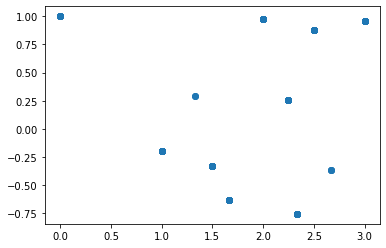

In [40]:
def cos_opc(x, p1, p2, p3):
    r = np.cos((p2 * ((x[0] ** 2) + ((p3 + p2) * (x[0] * p2)))))
    return r
print(set(pp4.data["opc"]))
plt.scatter(pp4.data["opc"], cos_opc(np.asarray(pp_merma_2.data[pp_merma_2.variables]).T,
                                     *pars_manual_merma2))

(array([  7.,   0.,   0.,  20.,   2., 120., 415.,  37.,  84.,  16.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

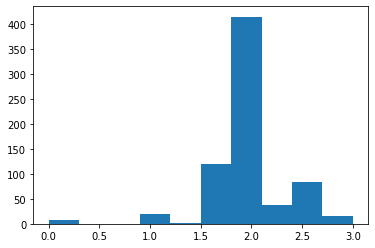

In [41]:
plt.hist(pp4.data["opc"])

In [42]:
def not_cos_merma_2(x, p1, p2, p3):
    r = x[1]*np.cos((p2 * ((x[0] ** 2) + ((p3 + p2) * (x[0] * p2)))))/((p3 ** 2) * x[1] + (-(p3) * x[2]))
    return r

not_cos_merma_2(np.asarray(pp_merma_2.data[pp_merma_2.variables]).T,
                                     *pars_manual_merma2)

array([ 1.4165415 ,  1.4165415 ,  1.26327378,  1.26327378, -0.7563742 ,
        1.4165415 ,  1.4165415 , -2.3514105 , -2.3514105 , -2.19779454,
       -0.57419498,  1.70216616, -0.61432863, -1.95999639,  1.4165415 ,
       -0.66049421,  1.70216616, -0.66049421, -2.19779454,  1.95799497,
       -2.26751647,  3.28368957,  1.92931684,  1.8605305 ,  3.28368957,
        1.8605305 ,  1.8605305 ,  1.8605305 ,  1.62944206,  1.95799497,
        1.70216616,  0.93962347,  1.95799497,  1.95799497,  1.4165415 ,
        1.95799497, -1.75796009, -1.95999639, -2.19779454, -1.95999639,
        0.65827686, -1.75796009,  0.65827686, -1.95999639, -1.95999639,
       -1.75796009, -1.95999639, -2.97528835, -2.66859582, -2.66859582,
       -2.97528835, -2.52811433, -2.97528835, -2.52811433,  0.99926892,
        1.70216616, -0.84360741, -0.84360741, -0.84360741, -0.84360741,
       -2.19779454, -1.95999639, -1.95999639, -1.95999639, -1.95999639,
        1.62944206, -2.06645628, -2.97528835, -2.06645628, -2.97

In [43]:
pars_manual_merma2

array([  1.      , -27.011126,   0.293669])

In [44]:
set(pp4.data["min_MCe3"])

{0.71, 1.58, 2.12, 3.0}

(array([ 96., 124.,  69., 204., 149.,   0.,  22.,   0.,   0.,  37.]),
 array([-0.15810752, -0.10978734, -0.06146715, -0.01314697,  0.03517322,
         0.0834934 ,  0.13181359,  0.18013377,  0.22845395,  0.27677414,
         0.32509432]),
 <BarContainer object of 10 artists>)

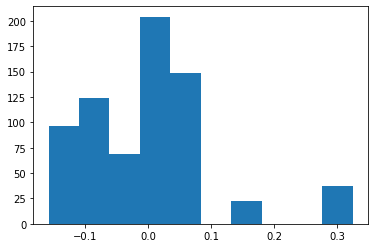

In [45]:
plt.hist(res_merma_manual["fitting"])

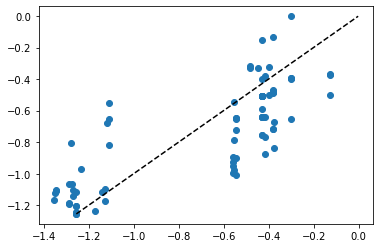

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


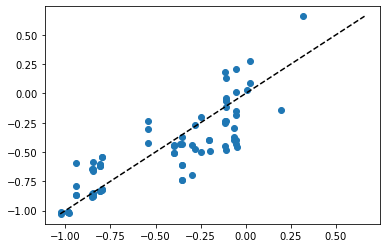

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


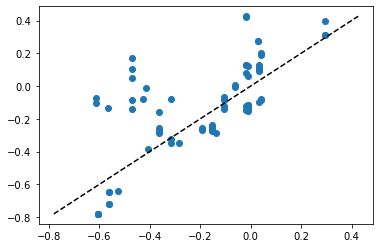

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


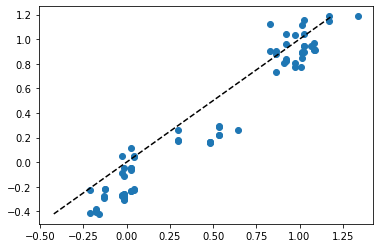

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


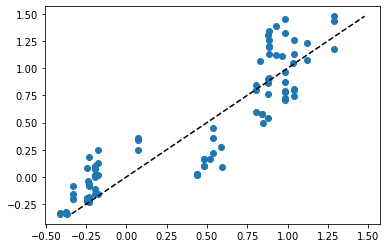

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


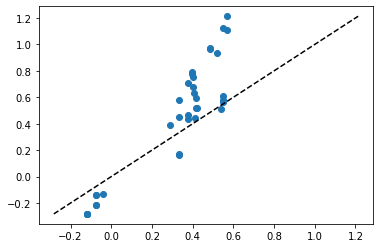

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


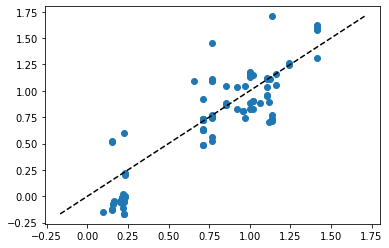

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


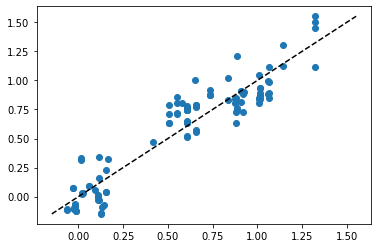

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


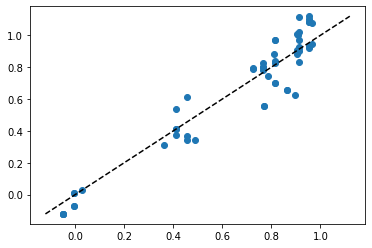

0.1659348790935023
0.04115160585600754
3.4189055059649767
1.534989467374854
0.7061825211145363
0.19553897369923015
0.20687580337700795
0.05236985387551595


In [46]:
metrics_lout, maes_lout, rmses_lout = pp_merma_2.LOUT(pp_merma_2.data, pars_manual4, pars_manual_merma2,
                               main_6, merma_2, ["ncoord", "MOG_b2", "Z", "r", "IE"],
                               ["opc", "min_MCe3", "m_Ce3"], 
                               special=["co", [-0.00116, -1256.76, 0.237922, 
                                               -5.524378, 0.615, 4323000.0]])

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


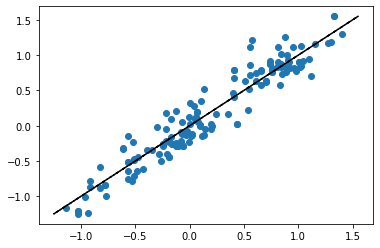

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


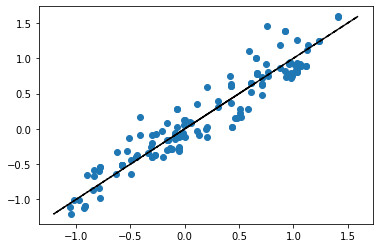

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


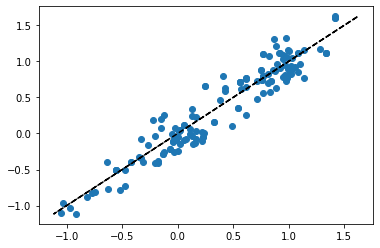

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


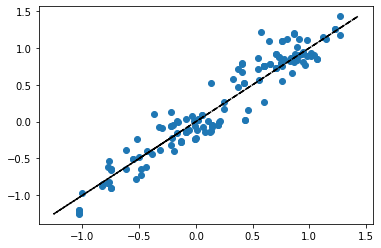

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


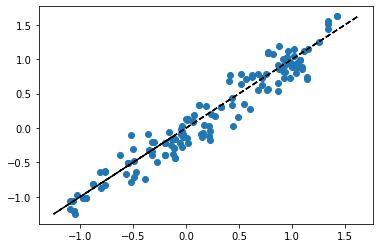

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


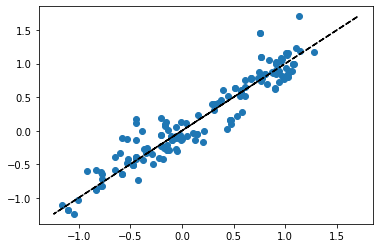

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


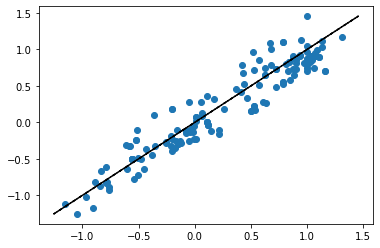

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


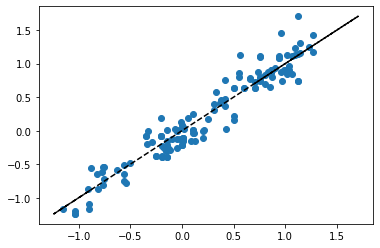

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


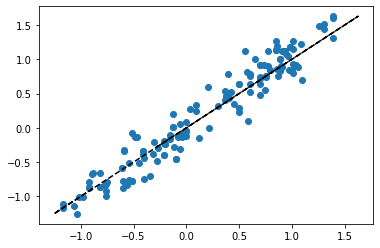

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


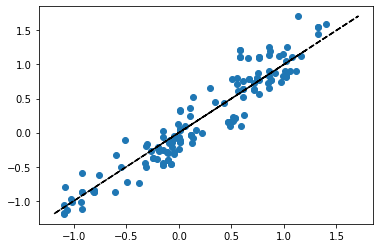

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


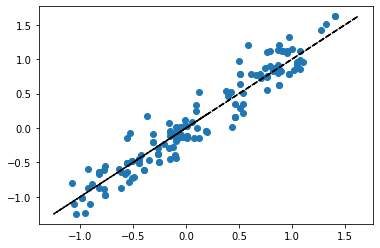

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


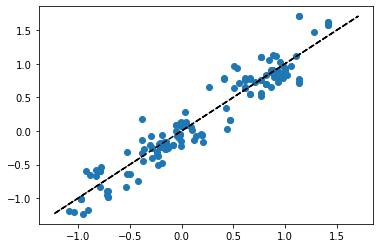

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


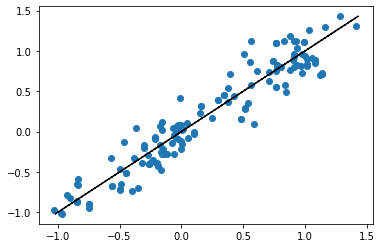

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


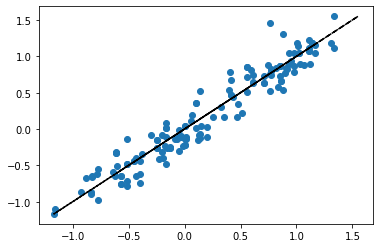

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


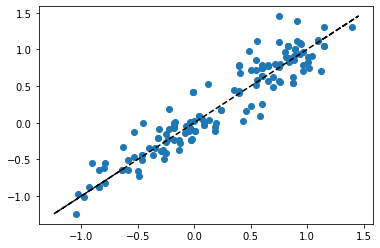

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


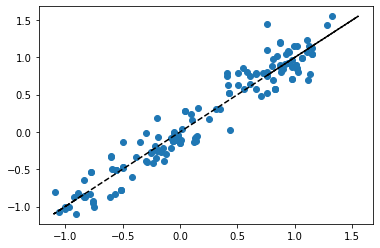

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


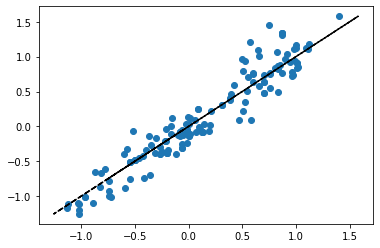

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


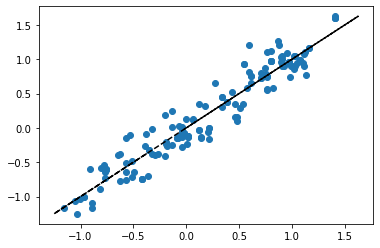

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


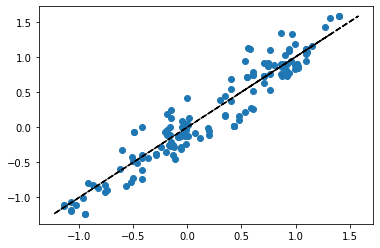

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


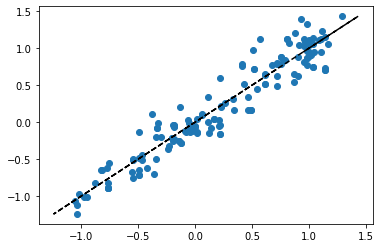

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


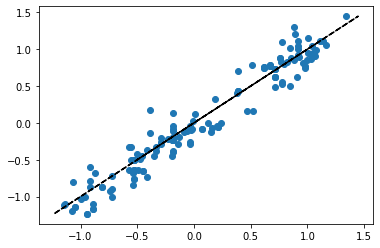

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


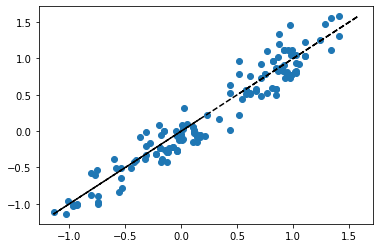

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


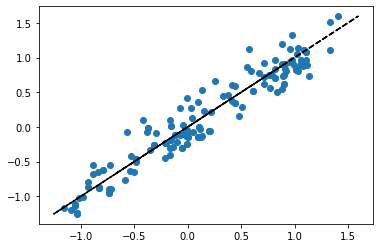

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


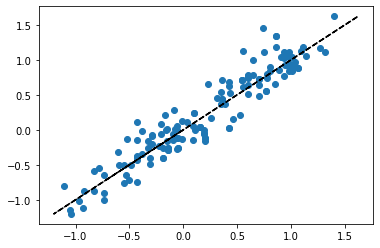

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


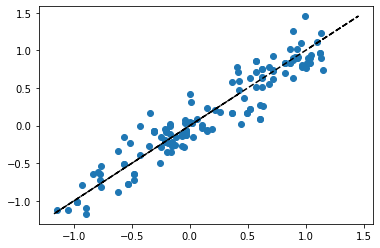

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


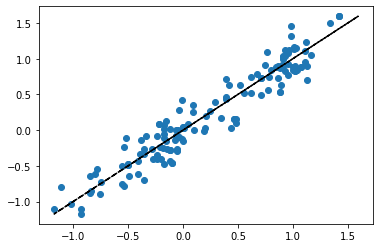

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


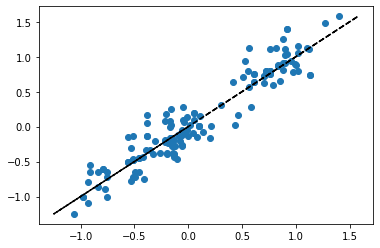

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


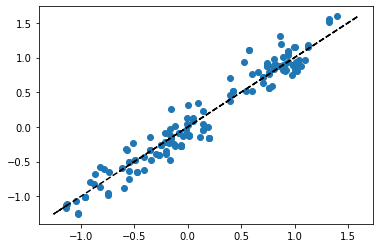

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


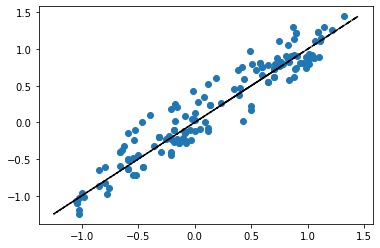

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


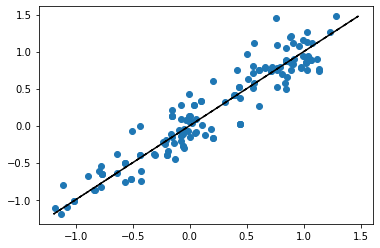

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


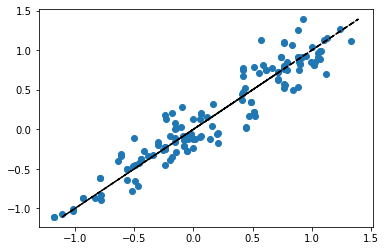

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


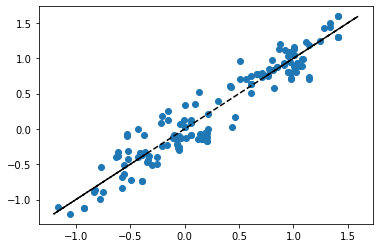

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


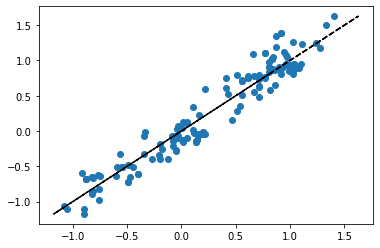

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


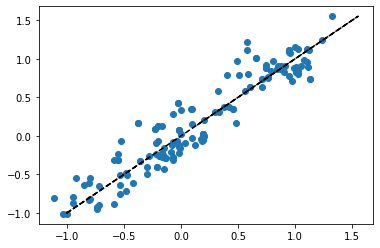

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


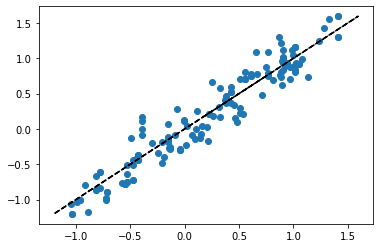

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


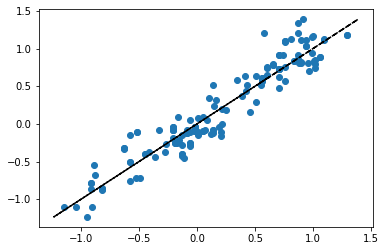

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


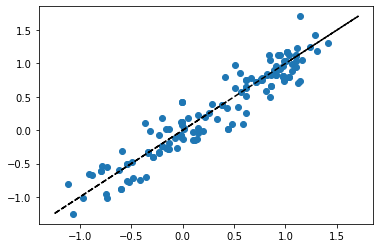

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


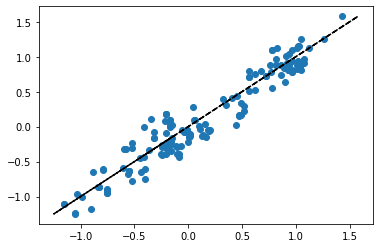

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


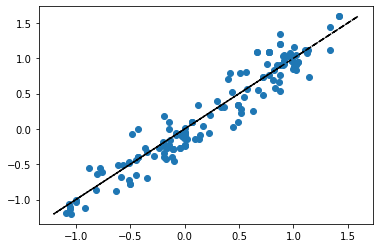

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


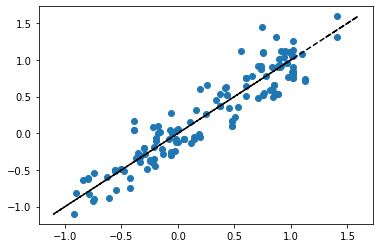

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


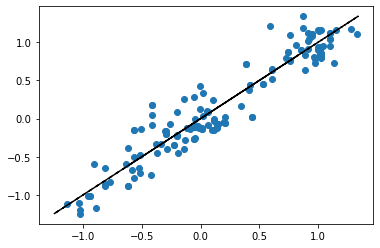

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


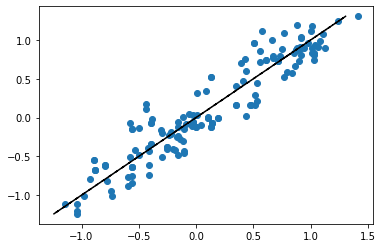

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


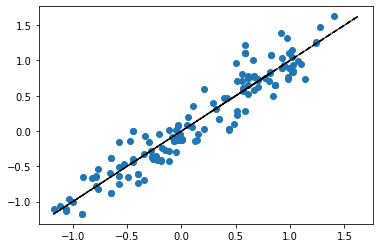

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


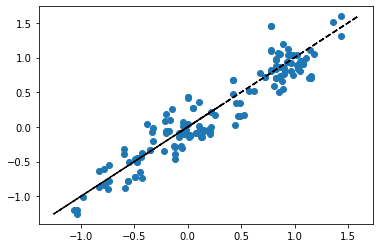

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


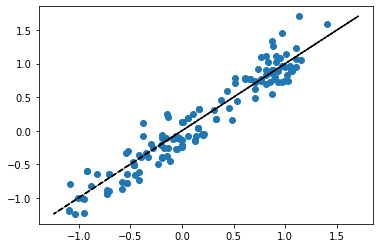

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


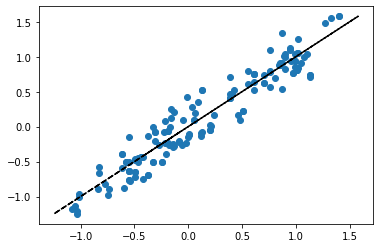

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


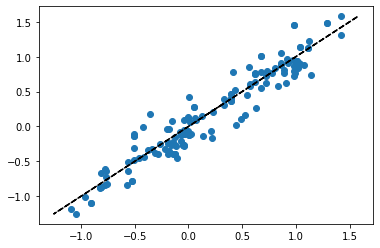

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


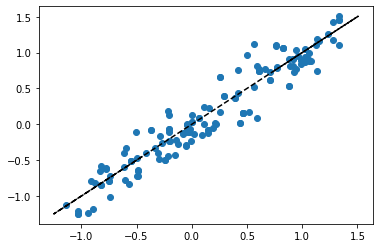

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


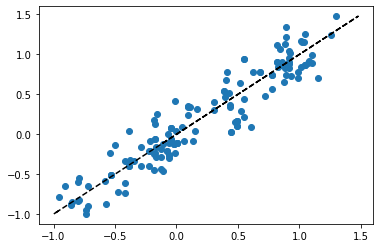

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


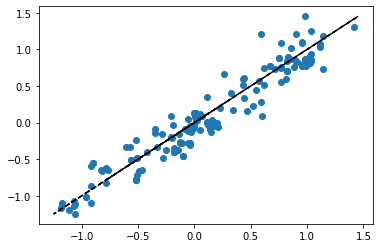

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


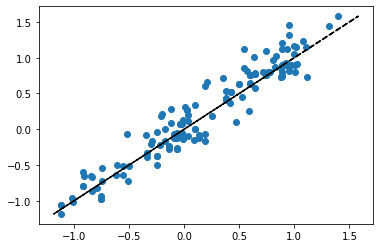

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


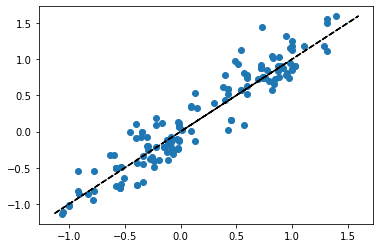

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


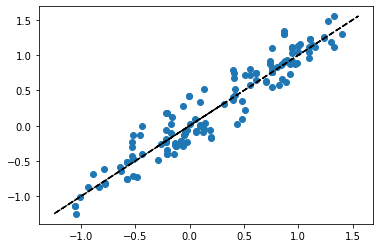

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


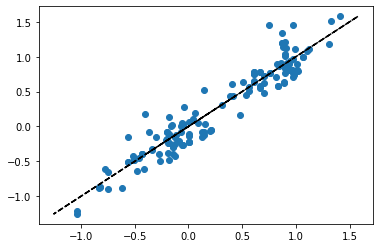

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


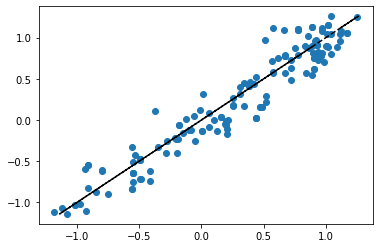

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


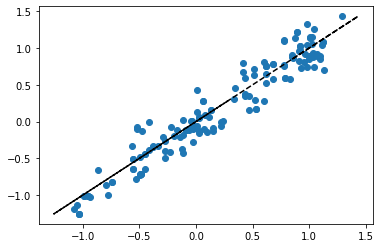

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


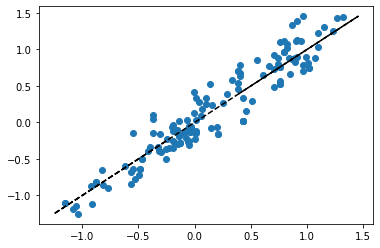

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


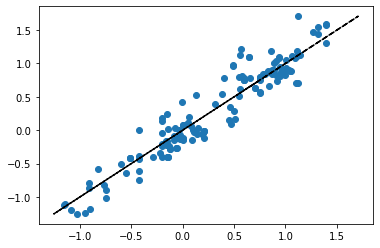

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


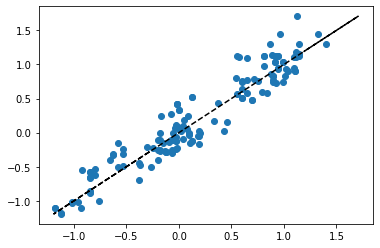

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


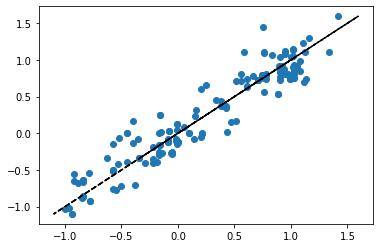

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


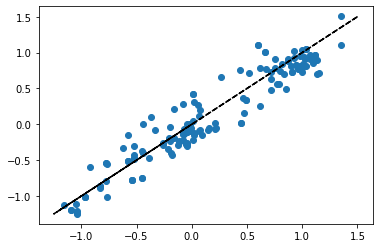

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


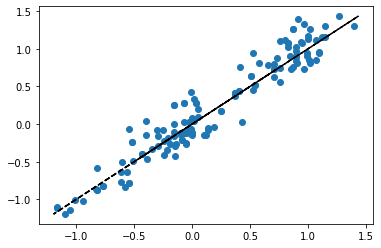

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


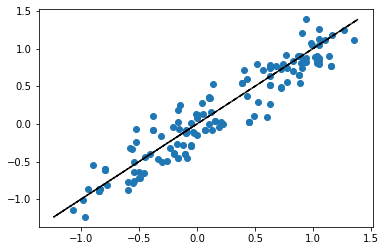

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


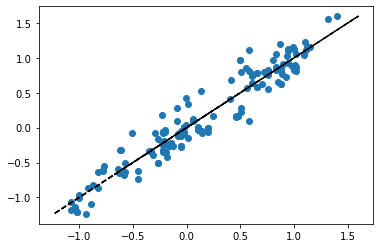

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


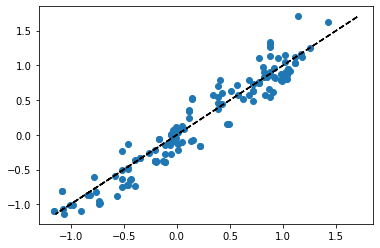

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


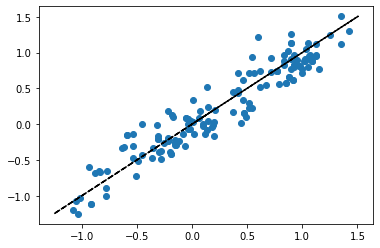

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


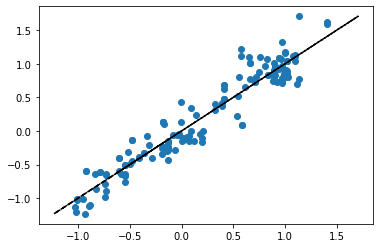

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


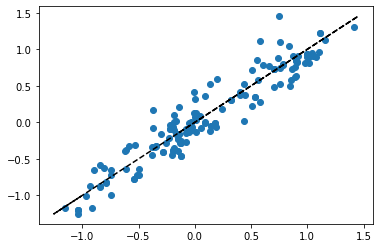

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


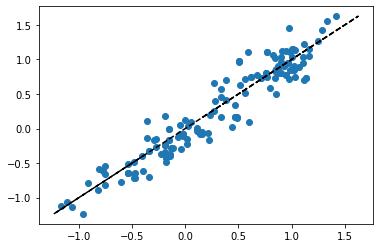

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


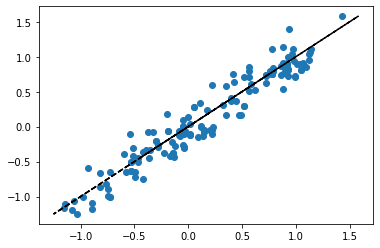

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


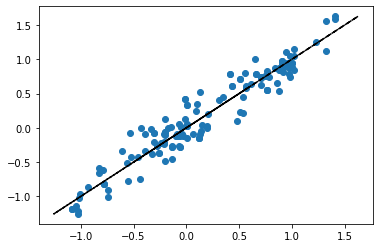

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


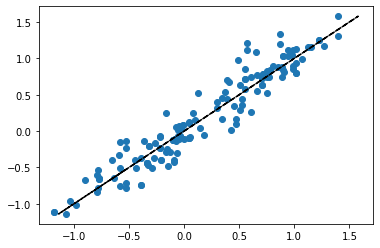

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


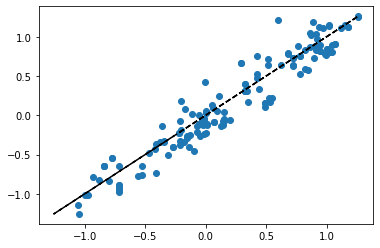

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


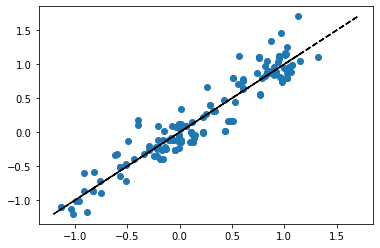

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


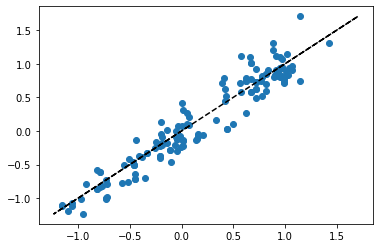

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


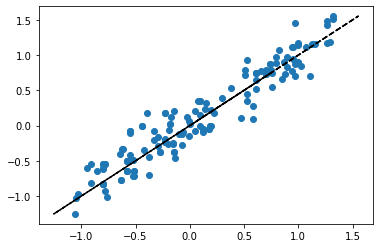

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


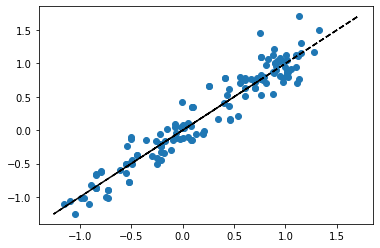

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


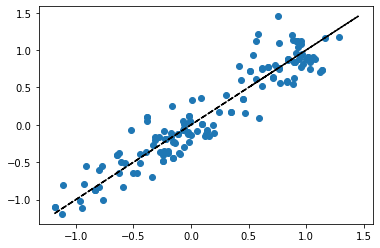

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


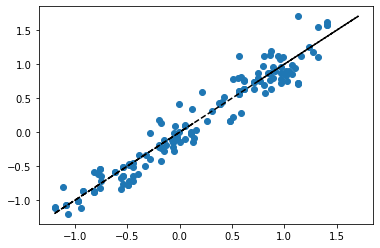

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


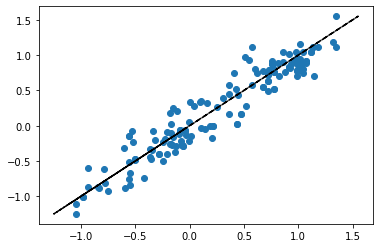

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


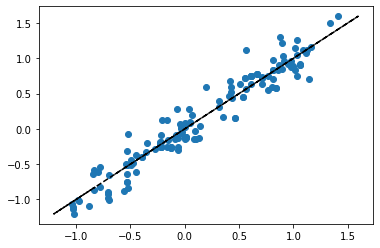

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


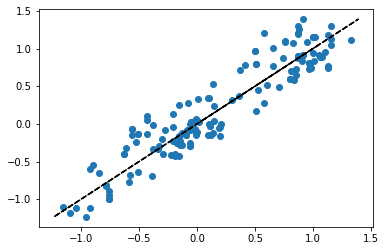

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


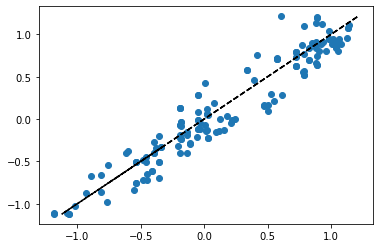

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


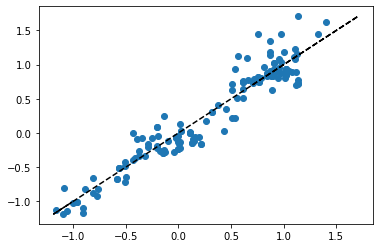

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


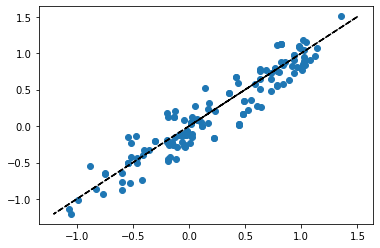

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


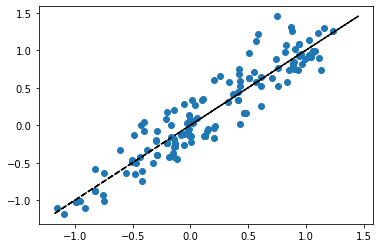

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


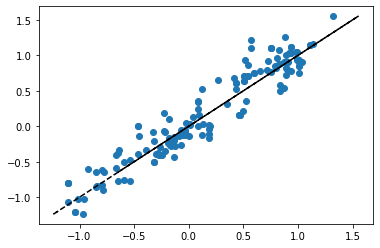

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


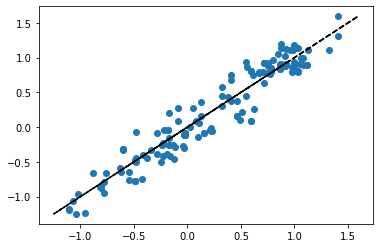

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


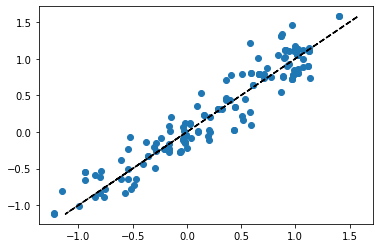

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


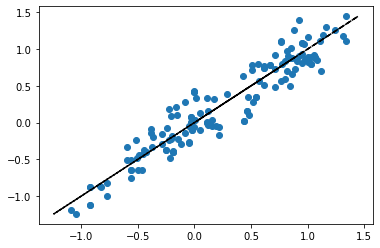

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


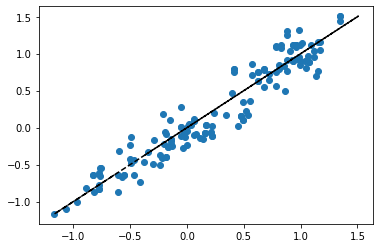

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


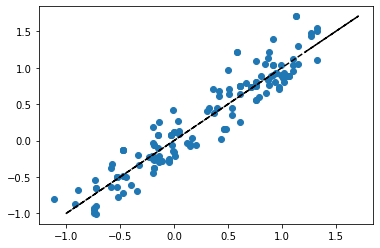

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


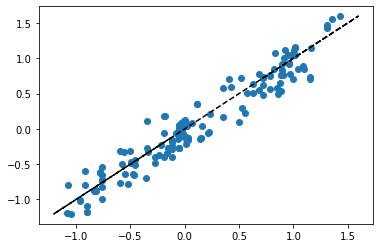

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


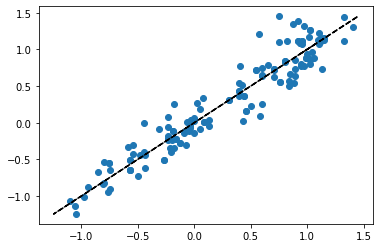

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


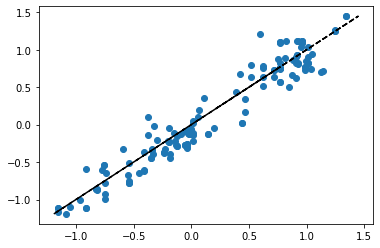

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


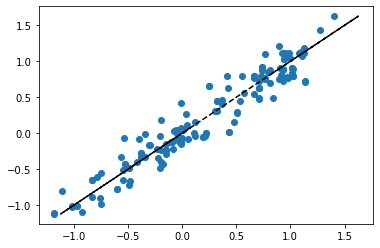

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


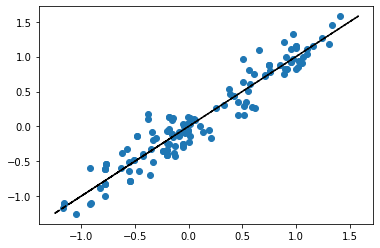

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


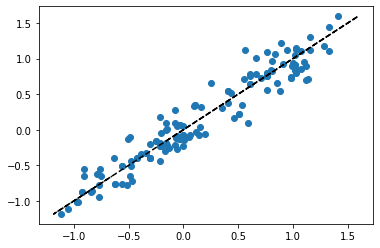

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


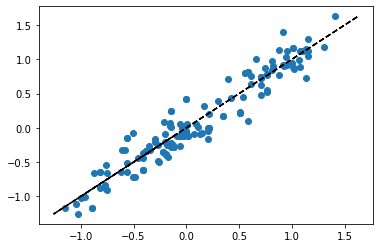

/home/jgeiger/anaconda3/envs/ceria_sac/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


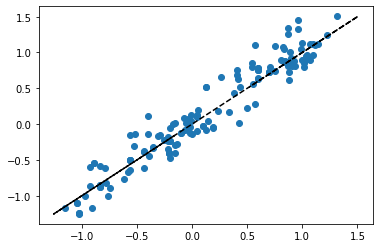

0.18324810993633484
0.011476689047904194
0.8800763588829009
0.018153495084351642
0.22679223124276907
0.013483724357071682
0.1550494209562811
0.010809725919082393
0.9099477297104377
0.0155097559534609
0.19627725046380637
0.012559401057636293


In [47]:
metrics_main, metrics_gen_val= pp_merma_2.validation(pp_merma_2.data, pars_manual4, pars_manual_merma2,
                               main_6, merma_2, ["ncoord", "MOG_b2", "Z", "r", "IE"],
                                                     ["opc", "min_MCe3", "m_Ce3"])

In [48]:
metrics_gen_val

[(0.1550494209562811, 0.010809725919082393),
 (0.19627725046380637, 0.012559401057636293),
 (0.9099477297104377, 0.0155097559534609)]

In [49]:
metrics_main

[(0.18324810993633484, 0.011476689047904194),
 (0.22679223124276907, 0.013483724357071682),
 (0.8800763588829009, 0.018153495084351642)]

In [50]:
main_per_metal = [pp4.eval_func(main_6, data_by_metal[i], 
                                  pp4.variables, pars_manual4, data_by_metal[i]["E"])
                 for i in pp4.metal_list]
merma_per_metal = [pp_merma_2.eval_func(merma_2, data_by_metal[i], 
                                          pp_merma_2.variables, pars_manual_merma2, 
                                          data_by_metal[i]["merma"])
                  for i in pp4.metal_list]

total_fits = [i["fitting"]+j["fitting"] for i,j in zip(main_per_metal, merma_per_metal)]

total_MAEs = [sum( abs(i-j) ) /len(j) for i,j in zip(total_fits,E_by_metal)]
total_fits[8] - E_by_metal[8] 

245    0.036075
247    0.035474
248    0.034478
250    0.033746
280    0.034699
281    0.034494
315   -0.048187
316   -0.049502
328   -0.035653
397    0.028481
403    0.090204
404    0.119627
408    0.060190
409    0.013785
412   -0.026076
413   -0.027014
433   -0.152107
436    0.211986
437    0.210107
448   -0.180349
450    0.267822
463    0.202246
464    0.198655
467    0.111778
468    0.109829
490    0.032071
520   -0.020293
521   -0.062379
526   -0.068190
529   -0.035205
530   -0.036688
542   -0.060228
545   -0.016455
547    0.075911
551   -0.025064
573   -0.075583
574    0.013569
589    0.002639
591   -0.007456
598   -0.011518
600    0.026247
601   -0.023334
602    0.015444
609    0.013303
616   -0.061718
617   -0.157065
618   -0.160784
622   -0.096618
624   -0.110183
626   -0.115287
639   -0.116711
640   -0.136311
641   -0.137893
645   -0.153606
655   -0.211500
656   -0.172390
Name: E, dtype: float64

# Simplifications

In [51]:
def main_6_test(x, p1, p2, p3, p4, p5, p6):
    r = (((((((((x[3] / (x[3] + np.cos((x[3] * (p6 / p2))))) ** 2) / p2) / 
              ((((x[2] + x[4]) ** (p4 + x[0])) * p2) + x[1])) / -(((x[1] + p5) ** 2)))
            + (((x[1] + p4) ** x[0]) * (p1 * (x[3]*-0.97488374 + 1.53433317)))) + p3) * x[0]) 
         + (x[1] ** 2))
    return r

res_main_manual_test = pp4.get_results(main_6_test, pp4.data, pp4.variables, pars_manual4, pp4.E)
res_main_manual_test["SSE"]

35.12858000069746

[-0.97488374  1.53433317]


Text(1.26, 0.30597965513698244, 'co')

Text(1.21, 0.3547238420984822, 'ni')

Text(1.38, 0.18899360642938356, 'cu')

Text(1.31, 0.25723546817548293, 'pd')

Text(1.28, 0.2864819803523826, 'pt')

Text(1.44, 0.13050058207558402, 'au')

Text(1.37, 0.19874244382168338, 'ir')

Text(1.35, 0.21824011860628323, 'rh')

Text(1.53, 0.0427610455448848, 'ag')

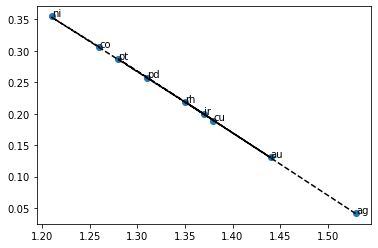

In [52]:


def test(x, a, b):
    r = a*x + b
    return r
params_test, coso = curve_fit(test,pp4.data["r"], np.cos(pp4.data["r"]), p0=[-1, 1])
print(params_test)
plt.plot(rs, np.cos(rs), "--", color="black")
for i,j,k in zip(rs, test(np.asarray(rs), *params_test), pp4.metal_list):
    plt.annotate(k,(i,j))
plt.scatter(rs, test(np.asarray(rs), *params_test))



In [53]:
def main_6_2_test(x, p1, p2, p3, p4, p5, p6):
    r = ((((x[3]**2*((x[2] + x[4]) ** (-p4 - x[0])) / (x[3] + np.cos((x[3] * (p6 / p2)))) ** 2) / p2) / 
          ((p2) + ((x[2] + x[4]) ** (-p4 - x[0]))*x[1])) / -(((x[1] + p5) ** 2)))*x[0]
    return r
term_6_2_test = main_6_2_test(np.asarray(pp4.data[pp4.variables]).T, *res_main_manual["pars"])
term_6_2 - term_6_2_test

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.77555756e-17,  2.77555756e-17,  2.77555756e-17,
        2.77555756e-17,  2.77555756e-17,  2.77555756e-17,  2.77555756e-17,
       -8.88178420e-16, -8.88178420e-16, -8.88178420e-16,  0.00000000e+00,
       -8.88178420e-16, -8.88178420e-16, -8.88178420e-16, -8.88178420e-16,
        2.77555756e-17,  2.77555756e-17, -8.88178420e-16,  2.77555756e-17,
        2.77555756e-17,  2.77555756e-17,  2.77555756e-17,  2.77555756e-17,
        2.77555756e-17,  2.77555756e-17,  2.77555756e-17, -8.88178420e-16,
        2.77555756e-17,  2.77555756e-17,  2.77555756e-17,  0.00000000e+00,
        2.77555756e-17,  

In [54]:
rmses_lout

[0.24232193932474996,
 0.19945302812330887,
 0.2235608505411304,
 0.1881646481914541,
 0.2480308078712589,
 0.2740240940198143,
 0.23009855341138954,
 0.14875477404402185,
 0.10747353486594365]

In [55]:
maes_lout

[0.1977704275780546,
 0.1553018810369715,
 0.16788884743617785,
 0.16083131006946366,
 0.205232873023829,
 0.2143408636194833,
 0.18157010961907405,
 0.12634863053531992,
 0.08412896892314659]

In [56]:
Gs = [0.22, 0.02, 0.24, 0.23, 0.05, 0.16, 0.37, 0.27, 0.03]
EXs = [0.42, 0.38, 0.43, 0.12, 0.16, 0.63, 0.57, 0.22, 0.27]

In [57]:
np.mean(Gs)

0.17666666666666667

In [58]:
np.mean(EXs)

0.35555555555555557

In [59]:
pp4.Standard_Deviation(Gs, np.mean(Gs))

0.12103718436910205

In [60]:
pp4.Standard_Deviation(EXs, np.mean(EXs))

0.1771377367411523

In [61]:
np.mean(E_by_metal_by_ncoord[6][2])

0.02691496559995814

In [62]:
pp4.Standard_Deviation(E_by_metal_by_ncoord[6][2], np.mean(E_by_metal_by_ncoord[6][2]))

0.21690100909495144

In [63]:
total_fits[0]

array([-1.04292984, -1.04292984, -1.04206842, -1.04206842, -0.95730158,
       -1.04292984, -1.04292984, -1.09569283, -1.09569283, -0.90912068,
       -1.16408004, -1.05350417, -1.1600027 , -0.92273722, -1.04292984,
       -1.15570204, -1.05350417, -1.15570204, -0.90912068, -1.05779236,
       -1.09620721, -0.74855906, -0.76072267, -0.75643448, -1.02009043,
       -0.76072267, -0.76072267, -0.74586015, -0.76072267, -0.61205099,
       -0.57290069, -0.8917086 , -1.08655941, -0.75643448, -0.61205099,
       -0.55817286, -0.55817286, -0.74855906, -0.50540602, -0.50540602,
       -0.88045168, -0.57290069, -0.4786332 , -0.74586015, -0.8917086 ,
       -0.74855906, -0.74855906, -0.61205099, -0.55817286, -0.55817286,
       -0.55817286, -0.55817286, -0.62566753, -0.8917086 , -0.75442894,
       -0.55817286, -0.55817286, -0.55817286, -0.55817286, -0.55817286,
       -0.55817286, -0.55817286, -0.2535919 , -0.59463891, -0.50540602,
       -0.50540602, -0.50540602, -0.50540602, -0.50540602, -0.62

In [64]:
data_by_metal["co"]

metal         E  ncoord   Z        IE      homo    MOG_81    MOG_97  \
0      co -1.254532       4  27  33.50000 -4.173892  3.985078  4.118778   
1      co -1.252940       4  27  33.50000 -4.173892  3.985078  4.118778   
2      co -1.248888       4  27  33.50000 -4.173892  3.985078  4.118778   
3      co -1.242027       4  27  33.50000 -4.173892  3.985078  4.118778   
4      co -1.235380       4  27  33.50000 -4.173892  3.985078  4.118778   
..    ...       ...     ...  ..       ...       ...       ...       ...   
162    co -0.325557       3  27  33.50000 -4.173892  3.985078  4.118778   
164    co -0.316250       2  27   7.88101 -4.173892  3.985078  4.118778   
224    co -0.150013       2  27  17.08440 -4.173892  3.985078  4.118778   
238    co -0.131584       2  27  17.08440 -4.173892  3.985078  4.118778   
310    co -0.001929       2  27  17.08440 -4.173892  3.985078  4.118778   

       MOG_b1    MOG_b2  min_MCe3  m_MCe3  m_Ce3  min_Ce3     r       opc  \
0   -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
1   -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
2   -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
3   -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
4   -0.577163 -0.577163      0.71    1.29   1.14     1.00  1.26  1.333333   
..        ...       ...       ...     ...    ...      ...   ...       ...   
162 -0.577163 -0.577163      0.71    1.00   1.14     1.00  1.26  2.000000   
164 -0.577163 -0.577163      1.58    1.58   3.00     3.00  1.26  2.000000   
224 -0.577163 -0.577163      0.71    1.41   1.41     1.41  1.26  2.000000   
238 -0.577163 -0.577163      0.71    1.14   1.00     1.00  1.26  2.000000   
310 -0.577163 -0.577163      1.58    1.58   1.41     1.41  1.26  2.000000   

                                            plot_label     merma  
0    M: Co; Coord: 4; OS: 3; IDs: 28_32_33; mean(d-... -0.311433  
1    M: Co; Coord: 4; OS: 3; IDs: 31_33_35; mean(d-... -0.309841  
2    M: Co; Coord: 4; OS: 3; IDs: 28_32_36; mean(d-... -0.305789  
3    M: Co; Coord: 4; OS: 3; IDs: 30_31_35; mean(d-... -0.298928  
4    M: Co; Coord: 4; OS: 3; IDs: 31_32_35; mean(d-... -0.292281  
..                                                 ...       ...  
162  M: Co; Coord: 3; OS: 3; IDs: 28_29_32; mean(d-...  0.320472  
164  M: Co; Coord: 2; OS: 1; IDs: 36; mean(d-Ce3Ce3...  0.255964  
224  M: Co; Coord: 2; OS: 2; IDs: 33_34; mean(d-Ce3...  0.428521  
238  M: Co; Coord: 2; OS: 2; IDs: 28_30; mean(d-Ce3...  0.446951  
310  M: Co; Coord: 2; OS: 2; IDs: 30_32; mean(d-Ce3...  0.576605  

[83 rows x 18 columns]

In [65]:
main_by_metal_by_ncoord = [ [ main_6(np.asarray(j[pp4.variables]).T, 
                                           *res_main_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]

merma_by_metal_by_ncoord = [ [ merma_2(np.asarray(j[pp_merma_2.variables]).T, 
                                           *res_merma_manual["pars"]) for j in i]
                              for i in data_by_metal_by_ncoord]

total_fits_by_metal_by_ncoord = [ [l+k for l,k in zip(i,j)] 
                                 for i,j in zip(main_by_metal_by_ncoord,
                                                merma_by_metal_by_ncoord)]
total_fits_by_metal_by_ncoord[0][2][7]

-1.095464426378486

In [66]:
data_by_metal_by_ncoord[0][2]

metal         E  ncoord   Z       IE      homo    MOG_81    MOG_97  \
0     co -1.254532       4  27  33.5000 -4.173892  3.985078  4.118778   
1     co -1.252940       4  27  33.5000 -4.173892  3.985078  4.118778   
2     co -1.248888       4  27  33.5000 -4.173892  3.985078  4.118778   
3     co -1.242027       4  27  33.5000 -4.173892  3.985078  4.118778   
4     co -1.235380       4  27  33.5000 -4.173892  3.985078  4.118778   
5     co -1.204827       4  27  33.5000 -4.173892  3.985078  4.118778   
6     co -1.202104       4  27  33.5000 -4.173892  3.985078  4.118778   
7     co -1.192495       4  27  51.2000 -4.173892  3.985078  4.118778   
8     co -1.183294       4  27  51.2000 -4.173892  3.985078  4.118778   
9     co -1.173725       4  27  33.5000 -4.173892  3.985078  4.118778   
10    co -1.167820       4  27  51.2000 -4.173892  3.985078  4.118778   
11    co -1.139080       4  27  33.5000 -4.173892  3.985078  4.118778   
12    co -1.119204       4  27  51.2000 -4.173892  3.985078  4.118778   
13    co -1.115654       4  27  33.5000 -4.173892  3.985078  4.118778   
14    co -1.115248       4  27  33.5000 -4.173892  3.985078  4.118778   
15    co -1.106459       4  27  51.2000 -4.173892  3.985078  4.118778   
16    co -1.103999       4  27  33.5000 -4.173892  3.985078  4.118778   
17    co -1.103201       4  27  51.2000 -4.173892  3.985078  4.118778   
18    co -1.099321       4  27  33.5000 -4.173892  3.985078  4.118778   
19    co -1.067260       4  27  33.5000 -4.173892  3.985078  4.118778   
20    co -1.065067       4  27  51.2000 -4.173892  3.985078  4.118778   
31    co -0.967506       4  27  33.5000 -4.173892  3.985078  4.118778   
51    co -0.819543       4  27  33.5000 -4.173892  3.985078  4.118778   
53    co -0.802180       4  27  51.2000 -4.173892  3.985078  4.118778   
71    co -0.676495       4  27  17.0844 -4.173892  3.985078  4.118778   
76    co -0.653102       4  27  33.5000 -4.173892  3.985078  4.118778   
98    co -0.550220       4  27  33.5000 -4.173892  3.985078  4.118778   

      MOG_b1    MOG_b2  min_MCe3  m_MCe3  m_Ce3  min_Ce3     r       opc  \
0  -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
1  -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
2  -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
3  -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
4  -0.577163 -0.577163      0.71    1.29   1.14     1.00  1.26  1.333333   
5  -0.577163 -0.577163      0.71    1.29   1.28     1.00  1.26  1.666667   
6  -0.577163 -0.577163      0.71    1.29   1.28     1.00  1.26  1.666667   
7  -0.577163 -0.577163      0.71    0.93   1.21     1.00  1.26  2.000000   
8  -0.577163 -0.577163      0.71    0.93   1.21     1.00  1.26  2.000000   
9  -0.577163 -0.577163      0.71    1.00   1.28     1.00  1.26  2.000000   
10 -0.577163 -0.577163      0.71    1.06   1.28     1.00  1.26  2.250000   
11 -0.577163 -0.577163      0.71    1.18   1.28     1.00  1.26  2.333333   
12 -0.577163 -0.577163      0.71    0.93   1.21     1.00  1.26  2.250000   
13 -0.577163 -0.577163      0.71    1.18   1.41     1.41  1.26  2.000000   
14 -0.577163 -0.577163      0.71    1.00   1.28     1.00  1.26  1.666667   
15 -0.577163 -0.577163      0.71    0.93   1.14     1.00  1.26  2.250000   
16 -0.577163 -0.577163      0.71    1.00   1.28     1.00  1.26  2.333333   
17 -0.577163 -0.577163      0.71    0.93   1.14     1.00  1.26  2.250000   
18 -0.577163 -0.577163      0.71    1.00   1.28     1.00  1.26  2.000000   
19 -0.577163 -0.577163      0.71    1.00   1.14     1.00  1.26  2.333333   
20 -0.577163 -0.577163      0.71    0.71   1.14     1.00  1.26  2.500000   
31 -0.577163 -0.577163      0.71    0.71   1.14     1.00  1.26  2.666667   
51 -0.577163 -0.577163      0.71    1.00   1.14     1.00  1.26  2.000000   
53 -0.577163 -0.577163      0.71    0.93   1.14     1.00  1.26  2.000000   
71 -0.577163 -0.577163      1.58    1.58   1.41     1.41  

In [67]:
span_ir = [0.20424969, 0.20424969, 0.08795887, 0.13586248, 0.13586248,
       0.20373531, 0.13993983, 0.13993983, 0.19597103, 0.19597103,
       0.20424969, 0.14424049, 0.1875838 , 0.14424049, 0.20424969,
       0.1875838 , 0.19527623, 0.21338311, 0.21338311, 0.20373531,
       0.21338311, 0.21338311]
pp4.Standard_Deviation(span_ir, np.mean(span_ir))

0.035808276068382494

In [68]:
data_by_metal["ir"]

metal         E  ncoord   Z    IE      homo    MOG_81    MOG_97    MOG_b1  \
216    ir -0.167292       4  77  40.0 -4.947573  4.297044  4.250405 -0.473476   
217    ir -0.165306       4  77  40.0 -4.947573  4.297044  4.250405 -0.473476   
226    ir -0.148127       4  77  40.0 -4.947573  4.297044  4.250405 -0.473476   
241    ir -0.127247       4  77  40.0 -4.947573  4.297044  4.250405 -0.473476   
244    ir -0.124081       4  77  40.0 -4.947573  4.297044  4.250405 -0.473476   
..    ...       ...     ...  ..   ...       ...       ...       ...       ...   
692    ir  1.452403       2  77   0.0 -4.947573  4.297044  4.250405 -0.473476   
697    ir  1.579275       3  77  17.0 -4.947573  4.297044  4.250405 -0.473476   
698    ir  1.594908       3  77  17.0 -4.947573  4.297044  4.250405 -0.473476   
699    ir  1.625722       3  77  17.0 -4.947573  4.297044  4.250405 -0.473476   
700    ir  1.706937       3  77  28.0 -4.947573  4.297044  4.250405 -0.473476   

       MOG_b2  min_MCe3  m_MCe3  m_Ce3  min_Ce3     r   opc  \
216 -0.473476      0.71    0.93   1.21      1.0  1.37  2.00   
217 -0.473476      0.71    0.93   1.21      1.0  1.37  2.00   
226 -0.473476      0.71    1.14   1.21      1.0  1.37  1.50   
241 -0.473476      0.71    1.06   1.28      1.0  1.37  2.25   
244 -0.473476      0.71    1.06   1.28      1.0  1.37  2.25   
..        ...       ...     ...    ...      ...   ...   ...   
692 -0.473476      3.00    3.00   3.00      3.0  1.37  0.00   
697 -0.473476      1.58    1.85   1.00      1.0  1.37  2.00   
698 -0.473476      1.58    1.85   1.00      1.0  1.37  2.00   
699 -0.473476      1.58    1.58   1.00      1.0  1.37  2.00   
700 -0.473476      0.71    1.00   1.14      1.0  1.37  2.00   

                                            plot_label     merma  
216  M: Ir; Coord: 4; OS: 4; IDs: 28_29_31_35; mean... -0.329285  
217  M: Ir; Coord: 4; OS: 4; IDs: 28_32_34_35; mean... -0.327299  
226  M: Ir; Coord: 4; OS: 4; IDs: 28_31_32_35; mean... -0.310119  
241  M: Ir; Coord: 4; OS: 4; IDs: 28_33_34_35; mean... -0.289240  
244  M: Ir; Coord: 4; OS: 4; IDs: 28_29_33_35; mean... -0.286074  
..                                                 ...       ...  
692  M: Ir; Coord: 2; OS: 0; IDs: 0; mean(d-Ce3Ce3)...  0.764129  
697  M: Ir; Coord: 3; OS: 2; IDs: 30_33; mean(d-Ce3...  0.497047  
698  M: Ir; Coord: 3; OS: 2; IDs: 33_36; mean(d-Ce3...  0.512680  
699  M: Ir; Coord: 3; OS: 2; IDs: 30_36; mean(d-Ce3...  0.543494  
700  M: Ir; Coord: 3; OS: 3; IDs: 28_29_32; mean(d-...  0.625255  

[95 rows x 18 columns]

In [69]:
pp8 = PostProcess("8_vars_common_bulk_fixed_4.txt", "./bms_full_input_final_mog_nl.csv",[300,300,40.03],
                 ["COMP", "BIC", "SSE", "A0", "A1", "A2", "A3", "A4","A5", "A6", "A7", "EQLAT", "EQSYMPY"],
                 ["ncoord", "MOG_b2", "Z", "r", "opc"], "E")

filt_8 = pp8.see_filt()

# filt_8

In [70]:
# filt_eqs_8 = list(filt_8["EQSYMPY"])
# filt_eqs_8

In [71]:
#result_8,pars_manual_8, pars_symp_8 = pp8.get_item('(tan((tanh(((((_a0_ + min_MCe3) + ncoord) / (_a1_ + Z)) + ((_a6_ * ((((r * _a7_) + ncoord) * (ncoord * ncoord)) + (_a2_ * IE))) * (((m_Ce3 / ncoord) * ((r / ((_a6_ + (min_MCe3 ** min_MCe3)) / r)) ** 2)) + _a5_)))) + _a6_)) + (_a2_ * opc))')
result_8,pars_manual_8, pars_symp_8 = pp8.get_item('(((((((cos((((_a0_ + _a5_) + (MOG_b2 / Z)) * ((_a5_ + _a7_) / (_a2_ ** ncoord)))) * (Z + _a0_)) ** 3) + _a3_) / r) + (-(_a5_) / (_a7_ ** 2))) * (((_a2_ + MOG_b2) / _a1_) * ncoord)) + ((_a7_ * opc) ** (Z / exp((r * ncoord)))))')
#result_8,pars_manual_8, pars_symp_8 = pp8.get_item('((sin(((((((_a7_ + (ncoord / (_a6_ + MOG_b2))) ** 3) + _a3_) + _a6_) + ((_a1_ / r) / (_a1_ + ((_a6_ * _a0_) * (Z ** 2))))) * -(Z))) ** 3) + (exp(sqrt((((_a6_ + _a3_) ** 2) / ncoord))) * ((_a2_ / Z) * (m_Ce3 / min_MCe3))))')

#pars_manual_8
new_pars_manual = [289.540622,-8.352290e+07,1.533173,
                   3.737680e+07,1.000000e+00,599.714637,1.000000e+00,0.005250]
new_pars_manual

<IPython.core.display.Latex object>

[289.540622, -83522900.0, 1.533173, 37376800.0, 1.0, 599.714637, 1.0, 0.00525]

In [72]:
print(result_8["EQLAT"])

\[\left(c_{1} opc\right)^{Z e^{- ncoord r}} + \frac{ncoord}{c_{6}} \left(MOG_{b2} + c_{2}\right) \left(\frac{1}{r} \left(c_{4} + \left(Z + c_{5}\right)^{3} \cos^{3}{\left (c_{2}^{- ncoord} \left(c_{1} + c_{3}\right) \left(\frac{MOG_{b2}}{Z} + c_{3} + c_{5}\right) \right )}\right) - \frac{c_{3}}{c_{1}^{2}}\right)\]


In [73]:
#res_8 = pp8.fitt_symp('(tan((tanh(((((_a0_ + min_MCe3) + ncoord) / (_a1_ + Z)) + ((_a6_ * ((((r * _a7_) + ncoord) * (ncoord * ncoord)) + (_a2_ * IE))) * (((m_Ce3 / ncoord) * ((r / ((_a6_ + (min_MCe3 ** min_MCe3)) / r)) ** 2)) + _a5_)))) + _a6_)) + (_a2_ * opc))')
#pp8.Metrics_symp
# vars 5 -> sinus ["ncoord", "MOG_b2", "Z", "r", "min_MCe3", "m_Ce3"]

#def res_8(x, p1, p2, p3, p4, p5, p6, p7, p8):
#    r = ((np.sin(((((((p8 + (x[0] / (p7 + x[1]))) ** 3) + p4) + p7) 
#                   + ((p2 / x[3]) / (p2 + ((p7 * p1) * (x[2] ** 2)))))
#                  * -(x[2]))) ** 3) + (np.exp(np.sqrt((((p7 + p4) ** 2) / x[0])))
#                                       * ((p3 / x[2]) * (x[5] / x[4]))))
#    return r
#pp8.eval_func(res_8, pp8.data, pp8.variables, pars_manual_8, pp8.E)

#vars 4 -> cosinus ["ncoord", "MOG_b2", "Z", "r", "opc"]

def res_8(x, p1, p2, p3, p4, p5, p6, p7, p8):
    r = (((((((np.cos((((p1 + p6) + (x[1] / x[2])) * ((p6 + p8) / (p3 ** x[0])))) 
               * (x[2] + p1)) ** 3) + p4) / x[3]) + (-(p6) / (p8 ** 2)))
          * (((p3 + x[1]) / p2) * x[0])) + ((p8 * x[4]) ** (x[2] / np.exp((x[3] * x[0])))))
    return r
new_pars_manual = [289.540622,-8.352290e+07,1.533173,
                   3.737680e+07,1.000000e+00,599.714637,1.000000e+00,0.005250]

pp8.eval_func(res_8, pp8.data, pp8.variables, new_pars_manual, pp8.E)

{'SSE': 36.889382342164694,
 'MAE': 0.17785537946088134,
 'r_sq': 0.8811888233809683,
 'rmse': 0.22939908581705687,
 'pars': [289.540622,
  -83522900.0,
  1.533173,
  37376800.0,
  1.0,
  599.714637,
  1.0,
  0.00525],
 'fitting': array([-1.0608091 , -1.0608091 , -1.0608091 , -1.0608091 , -1.07751781,
        -1.0608091 , -1.0608091 , -1.04666494, -1.04666494, -1.04666494,
        -1.03728496, -1.03434949, -1.03728496, -1.04666494, -1.0608091 ,
        -1.03728496, -1.03434949, -1.03728496, -1.04666494, -1.03434949,
        -1.02872908, -0.60587305, -0.6352505 , -0.60587305, -0.60587305,
        -0.60587305, -0.60587305, -0.60587305, -0.7090597 , -0.69663404,
        -0.69663404, -1.02340982, -0.69663404, -0.69663404, -0.7090597 ,
        -0.69663404, -0.56490264, -0.58337087, -0.70264713, -0.58337087,
        -0.60587305, -0.56490264, -0.60587305, -0.58337087, -0.58337087,
        -0.56490264, -0.58337087, -0.70264713, -0.56490264, -0.56490264,
        -0.58337087, -1.04666494, -0.583

In [74]:
pp8.data

metal         E  ncoord   Z     IE      homo    MOG_81    MOG_97  \
0      co -1.254532       4  27  33.50 -4.173892  3.985078  4.118778   
1      co -1.252940       4  27  33.50 -4.173892  3.985078  4.118778   
2      co -1.248888       4  27  33.50 -4.173892  3.985078  4.118778   
3      co -1.242027       4  27  33.50 -4.173892  3.985078  4.118778   
4      co -1.235380       4  27  33.50 -4.173892  3.985078  4.118778   
..    ...       ...     ...  ..    ...       ...       ...       ...   
696    rh  1.551345       3  45  18.08 -4.803866  4.197547  4.197547   
697    ir  1.579275       3  77  17.00 -4.947573  4.297044  4.250405   
698    ir  1.594908       3  77  17.00 -4.947573  4.297044  4.250405   
699    ir  1.625722       3  77  17.00 -4.947573  4.297044  4.250405   
700    ir  1.706937       3  77  28.00 -4.947573  4.297044  4.250405   

       MOG_b1    MOG_b2  min_MCe3  m_MCe3  m_Ce3  min_Ce3     r       opc  \
0   -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
1   -0.577163 -0.577163      0.71    1.47   1.28     1.00  1.26  1.666667   
2   -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
3   -0.577163 -0.577163      0.71    1.29   1.41     1.41  1.26  1.666667   
4   -0.577163 -0.577163      0.71    1.29   1.14     1.00  1.26  1.333333   
..        ...       ...       ...     ...    ...      ...   ...       ...   
696 -0.296247 -0.296247      1.58    1.85   1.00     1.00  1.35  2.000000   
697 -0.473476 -0.473476      1.58    1.85   1.00     1.00  1.37  2.000000   
698 -0.473476 -0.473476      1.58    1.85   1.00     1.00  1.37  2.000000   
699 -0.473476 -0.473476      1.58    1.58   1.00     1.00  1.37  2.000000   
700 -0.473476 -0.473476      0.71    1.00   1.14     1.00  1.37  2.000000   

                                            plot_label  
0    M: Co; Coord: 4; OS: 3; IDs: 28_32_33; mean(d-...  
1    M: Co; Coord: 4; OS: 3; IDs: 31_33_35; mean(d-...  
2    M: Co; Coord: 4; OS: 3; IDs: 28_32_36; mean(d-...  
3    M: Co; Coord: 4; OS: 3; IDs: 30_31_35; mean(d-...  
4    M: Co; Coord: 4; OS: 3; IDs: 31_32_35; mean(d-...  
..                                                 ...  
696  M: Rh; Coord: 3; OS: 2; IDs: 33_36; mean(d-Ce3...  
697  M: Ir; Coord: 3; OS: 2; IDs: 30_33; mean(d-Ce3...  
698  M: Ir; Coord: 3; OS: 2; IDs: 33_36; mean(d-Ce3...  
699  M: Ir; Coord: 3; OS: 2; IDs: 30_36; mean(d-Ce3...  
700  M: Ir; Coord: 3; OS: 3; IDs: 28_29_32; mean(d-...  

[701 rows x 17 columns]

In [75]:
total_fits[0]

array([-1.04292984, -1.04292984, -1.04206842, -1.04206842, -0.95730158,
       -1.04292984, -1.04292984, -1.09569283, -1.09569283, -0.90912068,
       -1.16408004, -1.05350417, -1.1600027 , -0.92273722, -1.04292984,
       -1.15570204, -1.05350417, -1.15570204, -0.90912068, -1.05779236,
       -1.09620721, -0.74855906, -0.76072267, -0.75643448, -1.02009043,
       -0.76072267, -0.76072267, -0.74586015, -0.76072267, -0.61205099,
       -0.57290069, -0.8917086 , -1.08655941, -0.75643448, -0.61205099,
       -0.55817286, -0.55817286, -0.74855906, -0.50540602, -0.50540602,
       -0.88045168, -0.57290069, -0.4786332 , -0.74586015, -0.8917086 ,
       -0.74855906, -0.74855906, -0.61205099, -0.55817286, -0.55817286,
       -0.55817286, -0.55817286, -0.62566753, -0.8917086 , -0.75442894,
       -0.55817286, -0.55817286, -0.55817286, -0.55817286, -0.55817286,
       -0.55817286, -0.55817286, -0.2535919 , -0.59463891, -0.50540602,
       -0.50540602, -0.50540602, -0.50540602, -0.50540602, -0.62

In [76]:
for i in pars_manual4:
    # print("{:e}".format(i))
    print('{:.2e}'.format(i))


-1.06e-03
-1.26e+03
2.68e-01
-5.52e+00
6.14e-01
4.32e+06


In [77]:
 pars_manual4


array([-1.06000000e-03, -1.25676526e+03,  2.67922000e-01, -5.52437800e+00,
        6.14414000e-01,  4.32292853e+06])

In [78]:
for i in pars_manual_merma2:
    print('{:.2e}'.format(i))

1.00e+00
-2.70e+01
2.94e-01


In [79]:
pars_manual_merma2

array([  1.      , -27.011126,   0.293669])